# Imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, Isomap
import statsmodels.formula.api as smf  # https://www.statsmodels.org/stable/mixed_linear.html
from Functions import get_quantile_groups, bool_from_index, name_from_index, sigmoid, zscore

## Directories etc.

In [8]:
data_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
    
param_names = ['alpha', 'beta', 'persev', 'forget', 'epsilon', 'wm', 'p_switch', 'p_reward', 'K']

In [115]:
wanted_cols = [
    'ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS', 'age_group',
    
    'bf_ACC', 'bf_RT', 'bf_RTsd', 'bf_ACC_delta', 'bf_RT_delta', 'bf_miss',
    'bf_WS', 'bf_LS', 'bf_WS_plus_LS', 'bf_stay_choice', 'bf_stay_motor',
    'bf_alpha', 'bf_nalpha', 'bf_beta', 'bf_forget',
    
    'rl_ACC', 'rl_RT', 'rl_RTsd', 'rl_ACC_delta', 'rl_RT_delta', 'rl_miss', # RL NS SLOPE (in RLWM_v02.csv)
    'rl_WS', 'rl_LS', 'rl_WS_plus_LS', 'rl_stay_motor', 'rl_stay_choice',
    'rl_alpha', 'rl_persev', 'rl_forget', 'rl_wm', 'rl_epsilon', 'rl_K',
    'rl_ACC_ns2_minus_ns5', 'rl_ACC_ns2_minus_ns5_delta', 'rl_RT_ns5_minus_ns2',
    'rl_lrn-fix_sig', 'rl_lrn-ns_sig', 'rl_lrn-delay_sig', 'rl_lrn-pcor_sig', 'rl_lrn-pinc_sig',

    'ps_ACC', 'ps_RT', 'ps_RTsd', 'ps_ACC_delta', 'ps_RT_delta', 'ps_miss',
    'ps_WS', 'ps_LS', 'ps_WS_plus_LS', 'ps_n_switches', 'ps_stay', 
    'ps_beta_BF', 'ps_persev_BF', 'ps_p_switch', 'ps_p_reward', 'ps_alpha', 'ps_beta_RL', 'ps_nalpha', 'ps_persev_RL',
]

In [10]:
# all_data_z[wanted_cols]

## Get data

In [11]:
bf_old = pd.read_csv(os.path.join(data_path, "BUTTERFLY.csv"))
bf_old = bf_old[['id'] +
        ['acc{}'.format(i) for i in range(1, 5)] +
        ['rtavg{}'.format(i) for i in range(1, 5)] +
        ['rtstd{}'.format(i) for i in range(1, 5)] +
        ['A', 'NA', 'B', 'F']]
bf_old = bf_old.rename(columns={'A': 'alpha', 'NA': 'nalpha', 'B': 'beta', 'F': 'forget'})
bf_old = bf_old.rename(columns={'acc{}'.format(i): 'ACC{}'.format(i) for i in range (1, 5)})
bf_old = bf_old.rename(columns={'rtavg{}'.format(i): 'RT{}'.format(i) for i in range (1, 5)})
bf_old = bf_old.rename(columns={'rtstd{}'.format(i): 'RTsd{}'.format(i) for i in range (1, 5)})
for col in ['RT{}'.format(i) for i in range (1, 5)] + ['RTsd{}'.format(i) for i in range (1, 5)]:
    bf_old[col] /= 1000
bf_params = bf_old[['id', 'alpha', 'nalpha', 'beta', 'forget']]
bf_params

id    alpha    nalpha     beta    forget
0     17  0.18653  0.029147   7.5840  0.133560
1     18  0.18648  0.018240  10.3210  0.032460
2     19  0.32447  0.002878  16.6320  0.011117
3     20  0.20189  0.036424  11.7270  0.038184
4     22  0.16689  0.072827  11.7230  0.070974
..   ...      ...       ...      ...       ...
270  465  0.18942  0.047580   9.5847  0.057780
271  466  0.29206  0.015143  11.4660  0.120670
272  467  0.21489  0.047446  10.4930  0.084509
273  468  0.21847  0.079979  14.2720  0.141510
274  469  0.21736  0.019183   8.8232  0.055956

[275 rows x 5 columns]

BUTTERFLY.csv
NaN indicates missing data
Columns1-8 (A-H): demographic information
-id: subject id
-group: 1 = 8-12 = kid, 2 = 13-17 = teen, 3 = 18-25 = RPP, 4 = 25-30 = adult
-age: age
-sex: 1 = male, 2 = female
-PDS: PDS-T1: T1-T3: T3-T4: T4
Columns 9-12 (I-L): average accuracy per block (total 120 trials, 30 trials per block)
-accX indicates accuracy in block X
Columns13-20 (M-T): average and standard deviation of reaction time per block
-rtavgX: mean RTfor block X
-rtstdX: standarddeviation of RT for block X
Columns 21-24(U-X): fit model parameters for the winning model so far (AABF)
-A:alpha positive (learning rate for positive RPE)
-NA: alpha negative
-B: beta
-F: forgetting

In [12]:
bf = pd.read_csv(os.path.join(data_path, "ButterflyAdditional.csv"))
bf = pd.merge(bf, bf_params, on='id')
bf = bf.rename(columns={'acc{}'.format(i+1): 'ACC_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'rt{}'.format(i+1): 'RT_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'acc': 'ACC', 'rt': 'RT', 'rt_sd': 'RTsd'})
bf = bf.rename(columns={'ws': 'WS', 'ls': 'LS'})
for col in [col for col in bf.columns if 'RT' in col]:
    bf[col] /= 1000
bf = bf.rename(columns={col: 'bf_{}'.format(col) for col in bf.columns})
bf

bf_id   bf_ACC  bf_ACC_early  bf_ACC_mid  bf_ACC_late    bf_RT  \
0       17  0.56667         0.650       0.725        0.325  1.33950   
1       18  0.80000         0.575       0.875        0.950  1.19270   
2       19  0.50000         0.500       0.500        0.500  0.83342   
3       20  0.85000         0.675       0.900        0.975  0.99265   
4       22  0.73333         0.600       0.825        0.775  1.51800   
..     ...      ...           ...         ...          ...      ...   
270    465  0.74167         0.575       0.800        0.850  1.11640   
271    466  0.60833         0.550       0.700        0.575  0.87618   
272    467  0.80000         0.825       0.800        0.775  1.29200   
273    468  0.71667         0.700       0.775        0.675  2.12680   
274    469  0.73333         0.675       0.825        0.700  1.13650   

     bf_RT_early  bf_RT_mid  bf_RT_late  bf_RTsd  bf_stay_choice  \
0        1.27260    1.33780     1.47720  0.69630         0.65517   
1        1.13960    1.22100     1.19880  0.53170         0.79310   
2        0.83970    0.82300     0.83755  0.20657         1.00000   
3        1.16290    1.02430     0.84556  0.52117         0.83621   
4        1.56260    1.42940     1.57780  1.03220         0.62069   
..           ...        ...         ...      ...             ...   
270      1.37600    1.06800     0.98635  0.52359         0.65517   
271      0.88236    0.97296     0.75243  0.32142         0.75000   
272      1.58270    1.08610     1.19510  0.83115         0.71552   
273      2.32480    2.46370     1.53470  1.53770         0.57759   
274      1.18930    1.21770     0.98975  0.58533         0.75000   

     bf_stay_motor    bf_WS    bf_LS  bf_miss  bf_alpha  bf_nalpha  bf_beta  \
0          0.34454  0.73846  0.45098      0.0   0.18653   0.029147   7.5840   
1          0.52941  0.84615  0.31579      0.0   0.18648   0.018240  10.3210   
2          1.00000  1.00000  0.00000      0.0   0.32447   0.002878  16.6320   
3          0.54622  0.92683  0.38235      0.0   0.20189   0.036424  11.7270   
4          0.44538  0.81081  0.71429      0.0   0.16689   0.072827  11.7230   
..             ...      ...      ...      ...       ...        ...      ...   
270        0.43697  0.82192  0.62791      0.0   0.18942   0.047580   9.5847   
271        0.56303  0.80000  0.31373      0.0   0.29206   0.015143  11.4660   
272        0.34454  0.84146  0.58824      0.0   0.21489   0.047446  10.4930   
273        0.51261  0.80282  0.77778      0.0   0.21847   0.079979  14.2720   
274        0.40336  0.81333  0.36585      0.0   0.21736   0.019183   8.8232   

     bf_forget  
0     0.133560  
1     0.032460  
2     0.011117  
3     0.038184  
4     0.070974  
..         ...  
270   0.057780  
271   0.120670  
272   0.084509  
273   0.141510  
274   0.055956  

[275 rows x 19 columns]

In [13]:
fc = pd.read_csv(os.path.join(data_path, "4choice.csv"))

# Wanted columns
fc = fc[['pID', 'pers', 'persER', 'discER', 'revER', 'irrel', 'novel', 'novelER', 'discTTC', 'revTTC', 'trial1visits',
         'cor1visits', 'prerevvisits', 'revvisits', 'revcor1visits', 'lastvisits', 'novelvisits', 'meanRT', 'discRT',
         'revRT', 'stdRT', 'RTvsTOT'] + ['betas_{}'.format(i) for i in range(1, 5)] + ['alpha', 'beta', 'ralpha']]

# Recode errors as accuracy
fc = fc.rename(columns={'persER': 'ACCpers', 'discER': 'ACCdisc', 'novelER': 'ACCnovel'})
for col in ['ACCpers', 'ACCdisc', 'ACCnovel']:
    fc[col] = 1 - fc[col]

# Rename columns
fc = fc.rename(columns={'meanRT': 'RT', 'discRT': 'RTdisc', 'revRT': 'RTrev', 'stdRT': 'RTsd'})
fc = fc.rename(columns={col: 'fc_{}'.format(col) for col in fc.columns})
fc

fc_pID  fc_pers  fc_ACCpers  fc_ACCdisc  fc_revER  fc_irrel  fc_novel  \
0        17        1    0.666667    0.320000  0.375000         1         1   
1        18        2    0.333333    1.000000  0.375000         0         1   
2        19        2    0.333333    0.833333  0.375000         0         1   
3        20        6    0.538462    0.666667  0.722222         3         4   
4        22        1    0.666667    0.555556  0.375000         1         1   
..      ...      ...         ...         ...       ...       ...       ...   
227     485        2    0.500000    0.600000  0.444444         1         1   
228     486        3    0.571429    0.625000  0.583333         2         2   
229     487        2    0.333333    0.625000  0.375000         0         1   
230     488        1    0.500000    0.555556  0.285714         0         1   
231     489        4    0.428571    0.310345  0.583333         1         2   

     fc_ACCnovel  fc_discTTC  fc_revTTC  ...   fc_RTrev   fc_RTsd  fc_RTvsTOT  \
0       0.666667          25          8  ...   5.166875  6.252144   19.867000   
1       0.666667           5          8  ...  11.596125  3.446076    1.233000   
2       0.666667           6          8  ...   4.342000  5.025114    3.767000   
3       0.692308           9         18  ...   9.277278  4.581754    3.151000   
4       0.666667           9          8  ...   6.441875  5.563094    0.733000   
..           ...         ...        ...  ...        ...       ...         ...   
227     0.750000          10          9  ...   5.018651  1.722870    0.933190   
228     0.714286           8         12  ...   4.111255  3.054055    4.733422   
229     0.666667           8          8  ...   2.416839  1.485993    3.166378   
230     0.500000           9          7  ...   6.062182  4.295897    3.200090   
231     0.714286          29         12  ...   4.611259  4.890632    7.433452   

     fc_betas_1  fc_betas_2  fc_betas_3  fc_betas_4  fc_alpha   fc_beta  \
0     -0.747755    2.393145   -1.200283   -0.876754  0.003477  0.999985   
1      1.024505    0.003234   -0.411955    0.526157  0.518217  0.880084   
2      1.152230    0.287367   -0.397495    0.452434  0.705434  0.054487   
3     -0.561582    2.062041   -2.808764    0.933507  0.272261  0.041704   
4      0.728011    0.921913   -0.387658    0.317687  0.140372  0.295324   
..          ...         ...         ...         ...       ...       ...   
227    0.668700    0.867902   -0.777079    1.150747       NaN       NaN   
228    0.281346    1.992270   -2.590093    1.709546       NaN       NaN   
229    1.385322   -0.207979    2.075924    2.386833       NaN       NaN   
230    1.217302    1.716272   -1.354100   -1.143206       NaN       NaN   
231   -0.816140    2.147580   -1.505612   -0.137622       NaN       NaN   

     fc_ralpha  
0     0.772359  
1     0.734655  
2     0.602075  
3     0.260541  
4     0.999997  
..         ...  
227        NaN  
228        NaN  
229        NaN  
230        NaN  
231        NaN  

[232 rows x 29 columns]

discER is the error rate (errors/trials) for the discrimination (first) phase. revER is the percentage error rate (errors/trials) for the reversal phase. 

Pers is the number of perseveration errors they made in the reversal phase, while persER is the percentage of total reversal phase errors that were perseveration errors (# perseveration errors/# reversal trials). The same goes for novel and novelER. Irrel is the number of irrelevant errors they made in reversal (so, not picking the novel box, and not perseverating on the correct box from the discrimination phase). 

discTTC is the number of trials they took to reach criterion on the discrimination phase; revTTC is the same in the reversal phase. So irrel + novel + pers should = revTTC. 

Trial1visits is how many different boxes they walk up to on the first trial of the entire task (1st trial of discrimination phase). Cor1visits is how many different boxes they walk up to after they have gotten their first star (so, correctly identified the box that they should continue to pick). 

Prerevvisits is how many boxes they walk up to on the last trial before the reversal. Revvisits is how many boxes they walk up to on the first reversal trial (but before they know that a reversal has even happened). These two numbers should be very similar. 

Revcor1visits is how many boxes they walk up to once they've realized that a reversal has taken place. This should go up a little.

Lastvisits is how many boxes they go up to on the last trial of the task (should be low if they've learned the correct reversal box).  

Novel visits is how many times in TOTAL they approach the completely new box during the reversal phase.

The labels persist for the RT columns: mean RT is self-explanatory, then it's the discrimination RT, then it's the reversal RT, then it's the standard deviation of each subjects' RTs. 

RTvsTOT is a measure of how the RT's changed over the course of the task. So it's the RT from trial 2 versus the RT from the very last trial. Last trial should be faster so the number should be positive, unless the subject is impulsive.

The regression I ran was a logistic regression subject-by-subject, predicting trial-by-trial accuracy (1 or 0). Betas_1 is the effect of cumulative previous correct trials. Betas_2 is the effect of delay since last correct trial. Betas_3 is the effect of reversal, and Betas_4 is the effect of boxes visited on that trial (walked up to but not selected). I ran an iteration with previous INcorrect trials when we found that that had some weird negative effect on accuracy in our other SLCN tasks... But that's the not the version here, I don't think.

Betas_1 through _4 are logistic regression betas with correct/incorrect as the predicted variable and things like previous number of correct trials as predictor. I don't remember now what went into that, but I can clarify if I can see the code again.

alpha is the estimated discrimination phase learning rate from a simple RL model with a separate alpha for the disc and reversal phases. beta is the softmax inverse temperature parameter. ralpha is the separate reversal phase learning rate. Amy will know all about these since I basically just ran her thesis code to obtain these parameters. :) These estimates were obtained in a non-hierarchical fashion, and some of these subjects have only 12 trials, so I wouldn't be too sure about them. I do think Anne ran some hierarchical versions of this modeling, though I don't remember where those numbers went, though I think they were unexciting.

PDS is pubertal development score (which I'm sure you know), Period_age is age of first periods for girls and adult women. Gender is 1 for males, 2 for females. And columbia is the puberty category (1-3) that they would have been assigned to using the criteria Michelle van Tieghem used at Columbia for her 4choice dataset.

In [82]:
rlwm = pd.read_csv(os.path.join(data_path, "RLWM.csv"))
rlwm = rlwm.dropna(subset=['IDs'])

# Sigmoid transform regression results
sig_cols = ['lrn-fix', 'lrn-delay', 'lrn-ns', 'lrn-pcor', 'lrn-pinc']
for col in sig_cols:
    print("Adding column {}_sig.".format(col))
    rlwm[col + '_sig'] = sigmoid(rlwm[col])
rlwm = rlwm.drop(columns=sig_cols)
# (gg.ggplot(rlwm, gg.aes('IDs', 'lrn-fix_sig'))
#  + gg.geom_point(color='red')
#  + gg.geom_smooth(color='red')
#  + gg.geom_point(gg.aes(y='lrn-ns_sig'), color='blue')
#  + gg.geom_smooth(gg.aes(y='lrn-ns_sig'), color='blue')
#  + gg.geom_point(gg.aes(y='lrn-pcor_sig'), color='green')
#  + gg.geom_smooth(gg.aes(y='lrn-pcor_sig'), color='green')
#  + gg.geom_point(gg.aes(y='lrn-pinc_sig'), color='pink')
#  + gg.geom_smooth(gg.aes(y='lrn-pinc_sig'), color='pink')
#  + gg.geom_point(gg.aes(y='lrn-delay_sig'), color='grey')
#  + gg.geom_smooth(gg.aes(y='lrn-delay_sig'), color='grey')
# )

# Rename
rlwm = rlwm.rename(columns={'ns{}-ely'.format(i): 'ACC_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-lat'.format(i): 'ACC_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-allt'.format(i): 'ACC_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_ely'.format(i): 'RT_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_lat'.format(i): 'RT_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_allt'.format(i): 'RT_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rtstd_allt'.format(i): 'RTsd_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'allns-allt': 'ACC', 'allns-ely': 'ACC_early', 'allns-lat': 'ACC_late'})
rlwm = rlwm.rename(columns={'allns-rt_allt': 'RT', 'allns-rt_ely': 'RT_early', 'allns-rt_lat': 'RT_late', 'allns-rtstd_allt': 'RTsd'})
rlwm = rlwm.rename(columns={'allns-motorstay': 'stay_motor', 'allns-choicestay': 'stay_choice', 'allns-WS': 'WS', 'allns-LS': 'LS'})
rlwm = rlwm.rename(columns={'RL alpha': 'alpha', 'pers': 'persev', 'WM phi': 'forget', 'WM rho': 'wm'})
rlwm = rlwm.rename(columns={'missing': 'miss'})
# print(rlwm.columns)

# Select columns
rlwm = rlwm[['IDs', 'lrn-fix_sig', 'lrn-ns_sig', 'lrn-delay_sig', 'lrn-pcor_sig', 'lrn-pinc_sig'] +
             ['ACC_early_ns{}'.format(i) for i in range(2, 6)] +   # ACC early per set size
             ['ACC_late_ns{}'.format(i) for i in range(2, 6)] +    # ACC late per set size
             ['ACC_ns{}'.format(i) for i in range(2, 6)] +         # ACC overall per set size
             ['ACC', 'ACC_early', 'ACC_late'] +                    # ACC overall overall
             ['RT_early_ns{}'.format(i) for i in range(2, 6)] +    # RT early per set size
             ['RT_late_ns{}'.format(i) for i in range(2, 6)] +     # RT late per set size
             ['RT_ns{}'.format(i) for i in range(2, 6)] +          # RT overall per set size
             ['RT', 'RT_early', 'RT_late'] +                       # RT overall
             ['WS', 'LS', 'stay_motor', 'stay_choice', 'RTsd', 'miss'] +
             ['alpha', 'persev', 'forget', 'wm', 'epsilon', 'K']#, 'nsslope', 'overall']]
           ]

# Add columns
rlwm['ACC_ns2_minus_ns5'] = rlwm['ACC_ns2'] - rlwm['ACC_ns5']
rlwm['ACC_ns2_minus_ns5_early'] = rlwm['ACC_early_ns2'] - rlwm['ACC_early_ns5']
rlwm['ACC_ns2_minus_ns5_late'] = rlwm['ACC_late_ns2'] - rlwm['ACC_late_ns5']
rlwm['ACC_ns2_minus_ns5_delta'] = rlwm['ACC_ns2_minus_ns5_late'] - rlwm['ACC_ns2_minus_ns5_early']
rlwm['RT_ns5_minus_ns2'] = rlwm['RT_ns5'] - rlwm['RT_ns2']

rlwm = rlwm.rename(columns={col: 'rl_{}'.format(col) for col in rlwm.columns})
rlwm.columns

Adding column lrn-fix_sig.
Adding column lrn-delay_sig.
Adding column lrn-ns_sig.
Adding column lrn-pcor_sig.
Adding column lrn-pinc_sig.


Index(['rl_IDs', 'rl_lrn-fix_sig', 'rl_lrn-ns_sig', 'rl_lrn-delay_sig',
       'rl_lrn-pcor_sig', 'rl_lrn-pinc_sig', 'rl_ACC_early_ns2',
       'rl_ACC_early_ns3', 'rl_ACC_early_ns4', 'rl_ACC_early_ns5',
       'rl_ACC_late_ns2', 'rl_ACC_late_ns3', 'rl_ACC_late_ns4',
       'rl_ACC_late_ns5', 'rl_ACC_ns2', 'rl_ACC_ns3', 'rl_ACC_ns4',
       'rl_ACC_ns5', 'rl_ACC', 'rl_ACC_early', 'rl_ACC_late',
       'rl_RT_early_ns2', 'rl_RT_early_ns3', 'rl_RT_early_ns4',
       'rl_RT_early_ns5', 'rl_RT_late_ns2', 'rl_RT_late_ns3', 'rl_RT_late_ns4',
       'rl_RT_late_ns5', 'rl_RT_ns2', 'rl_RT_ns3', 'rl_RT_ns4', 'rl_RT_ns5',
       'rl_RT', 'rl_RT_early', 'rl_RT_late', 'rl_WS', 'rl_LS', 'rl_stay_motor',
       'rl_stay_choice', 'rl_RTsd', 'rl_miss', 'rl_alpha', 'rl_persev',
       'rl_forget', 'rl_wm', 'rl_epsilon', 'rl_K', 'rl_ACC_ns2_minus_ns5',
       'rl_ACC_ns2_minus_ns5_early', 'rl_ACC_ns2_minus_ns5_late',
       'rl_ACC_ns2_minus_ns5_delta', 'rl_RT_ns5_minus_ns2'],
      dtype='object')

* Column 1: participant ID. nan if no data
* Columns 2-6 (A-F): logistic regression weights
    * lrn-fix: fixed effect
    * lrn-ns: set size effect
    * lrn-delay: delay effect
    * lrn-pcor: effect of number of previous correct trials
    * lrn-pinc: effect of number of previous incorrect trials
* Columns 7:15 (G-N): proportion of correct trials; nsX indicates set size
    * -ely: early trials (1-3 for each stim)
    * lat: late trials (last three for each stim)
* Columns 16-22 (O-V): correct RT
    * rtavg: mean RT
    * rtstd: std(RT)
    * nsX indicates set size
* Columns 23-28 (W-AB): fit model parameters
    * K capacity
    * RL alpha : learning rate
    * WM rho: WM weight
    * WM phi: forgetting
    * epsilon: noise
    * pers: perseveration

In [84]:
ps = pd.read_csv(os.path.join(data_path, "ProbSwitch.csv"), index_col=0)
# ps['p_switch_inv'] = 1 - ps.p_switch
ps = ps.drop(columns=['calpha', 'cnalpha'])
# ps = ps.rename(columns={'median_cor_RT': 'RT', 'mean_ACC': 'ACC'})
ps = ps.rename(columns={'win_stay': 'WS', 'lose_shift': 'LS', 'percent_missed': 'miss'})
for col in ['RT.{}'.format(i) for i in range(1, 4)] + ['RT', 'RTsd']:
    ps[col] /= 1000
for col in ['RT', 'ACC']:
    ps = ps.rename(columns={'{}.{}'.format(col, i+1): '{}_{}'.format(col, t) for i, t in enumerate(('early', 'mid', 'late'))})
ps = ps.rename(columns={col: 'ps_{}'.format(col) for col in ps.columns})
ps.columns

Index(['ps_sID', 'ps_beta_BF', 'ps_persev_BF', 'ps_p_switch', 'ps_p_reward',
       'ps_alpha', 'ps_beta_RL', 'ps_nalpha', 'ps_persev_RL', 'ps_ACC',
       'ps_stay', 'ps_WS', 'ps_LS', 'ps_RTsd', 'ps_RT', 'ps_n_switches',
       'ps_ACC_early', 'ps_RT_early', 'ps_ACC_mid', 'ps_RT_mid', 'ps_ACC_late',
       'ps_RT_late', 'ps_miss'],
      dtype='object')

## Create all_data and all_data_long

In [85]:
bf.shape, fc.shape, rlwm.shape, ps.shape

((275, 19), (232, 29), (300, 53), (291, 23))

In [86]:
bf_ids = np.unique(bf.bf_id)
rl_ids = np.unique(rlwm.rl_IDs)
ps_ids = np.unique(ps.ps_sID)
fc_ids = np.unique(fc.fc_pID)
fc_ids_clean = [id for id in fc.fc_pID if (id < 300) or (id > 400)]

print("Butterfly data (n={}): {}".format(len(bf_ids), bf_ids))
print("RLWM data (n={}): {}".format(len(rl_ids), rl_ids))
print("ProbSwitch data (n={}): {}".format(len(ps_ids), ps_ids))
print("4-choice data (n={}; after excluding Columbia: {}): {}".format(len(fc_ids), len(fc_ids_clean), fc_ids))

Butterfly data (n=275): [ 17  18  19  20  22  23  24  25  27  28  29  30  31  32  35  36  37  38
  40  42  43  44  45  46  48  49  50  51  53  55  56  57  59  60  65  66
  67  68  70  71  72  73  74  76  77  78  80  81  82  83  85  86  87  90
  91  92  93  94  95  96  97  98  99 100 101 102 104 105 106 109 110 111
 112 113 115 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 137 138 139 140 141 142 144 145 147 148 149 150 151 152
 153 154 155 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 174 175 176 177 178 180 181 182 183 184 185 188 189 190 191 193 194
 195 196 198 199 200 201 202 204 205 206 208 209 210 212 213 214 215 217
 218 219 220 221 300 301 302 303 304 305 306 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 325 326 328 329 330 331 332 333 334
 335 337 338 339 342 343 345 347 348 349 350 351 352 353 354 357 359 360
 361 362 363 364 365 409 410 411 412 413 415 416 417 419 420 421 422 423
 424 426 427 428 429 430 43

In [93]:
# Merge all tasks
bf_rlwm = bf.merge(rlwm, left_on='bf_id', right_on='rl_IDs')  # bf + rlwm
# fc_bf_rlwm = fc.merge(bf_rlwm, left_on='fc_pID', right_on='bf_id')  # + fc
# all_data = fc_bf_rlwm.merge(ps, left_on='fc_pID', right_on='ps_sID')  # + ps
all_data = bf_rlwm.merge(ps, left_on='bf_id', right_on='ps_sID')  # + ps
all_data = all_data.rename(columns={'bf_id': 'ID'})
all_data = all_data.drop(columns=['rl_IDs', 'ps_sID'])

# Add ages data
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))
ages_cols = ['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS']
category_cols = ['minus', 'delta', 'stay', 'plus', 'WS', 'LS', 'ACC', 'RT', 'lrn', 'miss']
all_data = all_data.merge(ages[ages_cols])
all_data['age_group'], _ = get_quantile_groups(all_data, 'PreciseYrs')

# Add extra columns
for task in ['bf', 'rl', 'ps']:
    all_data['{}_ACC_delta'.format(task)] = all_data['{}_ACC_late'.format(task)] - all_data['{}_ACC_early'.format(task)]
    all_data['{}_RT_delta'.format(task)] = all_data['{}_RT_early'.format(task)] - all_data['{}_RT_late'.format(task)]
    all_data['{}_WS_plus_LS'.format(task)] = all_data['{}_WS'.format(task)] + all_data['{}_LS'.format(task)]

# Confirm
print("Final number of participants: {}".format(all_data.shape[0]))
print("Columns: {}".format(all_data.columns[:70]))
print("Columns: {}".format(all_data.columns[70:]))

Final number of participants: 256
Columns: Index(['ID', 'bf_ACC', 'bf_ACC_early', 'bf_ACC_mid', 'bf_ACC_late', 'bf_RT',
       'bf_RT_early', 'bf_RT_mid', 'bf_RT_late', 'bf_RTsd', 'bf_stay_choice',
       'bf_stay_motor', 'bf_WS', 'bf_LS', 'bf_miss', 'bf_alpha', 'bf_nalpha',
       'bf_beta', 'bf_forget', 'rl_lrn-fix_sig', 'rl_lrn-ns_sig',
       'rl_lrn-delay_sig', 'rl_lrn-pcor_sig', 'rl_lrn-pinc_sig',
       'rl_ACC_early_ns2', 'rl_ACC_early_ns3', 'rl_ACC_early_ns4',
       'rl_ACC_early_ns5', 'rl_ACC_late_ns2', 'rl_ACC_late_ns3',
       'rl_ACC_late_ns4', 'rl_ACC_late_ns5', 'rl_ACC_ns2', 'rl_ACC_ns3',
       'rl_ACC_ns4', 'rl_ACC_ns5', 'rl_ACC', 'rl_ACC_early', 'rl_ACC_late',
       'rl_RT_early_ns2', 'rl_RT_early_ns3', 'rl_RT_early_ns4',
       'rl_RT_early_ns5', 'rl_RT_late_ns2', 'rl_RT_late_ns3', 'rl_RT_late_ns4',
       'rl_RT_late_ns5', 'rl_RT_ns2', 'rl_RT_ns3', 'rl_RT_ns4', 'rl_RT_ns5',
       'rl_RT', 'rl_RT_early', 'rl_RT_late', 'rl_WS', 'rl_LS', 'rl_stay_motor',
       'rl_

In [94]:
all_data.head()

ID   bf_ACC  bf_ACC_early  bf_ACC_mid  bf_ACC_late    bf_RT  bf_RT_early  \
0  17  0.56667         0.650       0.725        0.325  1.33950       1.2726   
1  18  0.80000         0.575       0.875        0.950  1.19270       1.1396   
2  19  0.50000         0.500       0.500        0.500  0.83342       0.8397   
3  20  0.85000         0.675       0.900        0.975  0.99265       1.1629   
4  22  0.73333         0.600       0.825        0.775  1.51800       1.5626   

   bf_RT_mid  bf_RT_late  bf_RTsd  ...  age_group  bf_ACC_delta  bf_RT_delta  \
0     1.3378     1.47720  0.69630  ...       0.25        -0.325     -0.20460   
1     1.2210     1.19880  0.53170  ...       0.50         0.375     -0.05920   
2     0.8230     0.83755  0.20657  ...       0.50         0.000      0.00215   
3     1.0243     0.84556  0.52117  ...       0.75         0.300      0.31734   
4     1.4294     1.57780  1.03220  ...       1.00         0.175     -0.01520   

   bf_WS_plus_LS  rl_ACC_delta  rl_RT_delta  rl_WS_plus_LS  ps_ACC_delta  \
0        1.18944       0.35000      0.82780        1.73865        -0.075   
1        1.16194       0.30000      0.21165        1.81217         0.050   
2        1.00000       0.46667      0.14508        1.82338        -0.025   
3        1.30918       0.26667      0.19444        1.85598        -0.025   
4        1.52510       0.31666      0.21055        1.79059         0.125   

   ps_RT_delta  ps_WS_plus_LS  
0     0.093537       0.785714  
1     0.031057       0.729032  
2     0.077876       0.722581  
3    -0.029955       0.741935  
4    -0.062303       0.716129  

[5 rows x 108 columns]

In [95]:
all_data_z = all_data[ages_cols + ['age_group']]
for col in [col for col in all_data.columns if not col in ages_cols + ['age_group']]:
    all_data_z[col] = zscore(all_data[col])
    
all_data_z

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ID  PreciseYrs        BMI  Gender       meanT   PDS  age_group  \
0     17    8.657084  18.200751     2.0         NaN  2.50       0.25   
1     18   12.637919  16.157863     2.0         NaN  2.25       0.50   
2     19   12.637919  14.316358     1.0         NaN  1.25       0.50   
3     20   14.543463  17.433768     1.0  120.649667  2.80       0.75   
4     22   16.490075  22.709959     1.0  147.334443  3.00       1.00   
..   ...         ...        ...     ...         ...   ...        ...   
251  465   22.333333        NaN     2.0         NaN   NaN       2.00   
252  466   20.083333        NaN     1.0         NaN   NaN       2.00   
253  467   18.750000        NaN     2.0         NaN   NaN       2.00   
254  468   21.833333        NaN     2.0         NaN   NaN       2.00   
255  469   19.000000        NaN     2.0         NaN   NaN       2.00   

       bf_ACC  bf_ACC_early  bf_ACC_mid  ...   ps_miss  bf_ACC_delta  \
0   -1.316224     -0.219717   -0.348717  ...  1.575791     -2.967827   
1    0.243251     -0.732693    0.485665  ... -0.300500      1.500825   
2   -1.761817     -1.245669   -1.600291  ... -0.300500     -0.893096   
3    0.577429     -0.048725    0.624729  ... -0.300500      1.022041   
4   -0.202342     -0.561701    0.207538  ... -0.300500      0.224067   
..        ...           ...         ...  ...       ...           ...   
251 -0.146601     -0.732693    0.068474  ... -0.300500      0.862446   
252 -1.037787     -0.903685   -0.487781  ... -0.300500     -0.733501   
253  0.243251      0.977226    0.068474  ... -0.300500     -1.212285   
254 -0.313690      0.122267   -0.070590  ...  1.575791     -1.052690   
255 -0.202342     -0.048725    0.207538  ... -0.300500     -0.733501   

     bf_RT_delta  bf_WS_plus_LS  rl_ACC_delta  rl_RT_delta  rl_WS_plus_LS  \
0      -1.096424      -0.337602      0.186029     2.724397      -0.427422   
1      -0.672216      -0.553128     -0.315075     0.030096       0.202937   
2      -0.493225      -1.822303      1.355305    -0.261001       0.299052   
3       0.426350       0.600838     -0.649111    -0.045159       0.578564   
4      -0.543845       2.293071     -0.148107     0.025286       0.017911   
..           ...            ...           ...          ...            ...   
251     0.637317       1.703156      1.355305    -0.032172       0.859276   
252    -0.120424      -0.930965     -0.983247    -0.190905       1.201121   
253     0.631336       1.545391     -0.482043    -0.353617       0.635238   
254     1.805641       2.728042     -0.315075     0.345244       1.072768   
255     0.082695      -0.418013      0.186029     1.656253      -0.758807   

     ps_ACC_delta  ps_RT_delta  ps_WS_plus_LS  
0       -1.156824     0.911645       0.028316  
1        0.403761     0.379935      -0.742279  
2       -0.532590     0.778374      -0.829989  
3       -0.532590    -0.139277      -0.566859  
4        1.340113    -0.414564      -0.917699  
..            ...          ...            ...  
251     -0.220473    -0.222028      -0.300356  
252      0.403761     0.287561       0.327108  
253     -0.220473     1.491841       1.791190  
254     -1.236854     0.684614      -0.114711  
255     -2.093176    -1.353137      -0.823243  

[256 rows x 108 columns]

In [96]:
choice_param_cols = []
update_param_cols = []
for col in all_data_z.columns:
    if ('beta' in col) or ('epsilon' in col) or ('forget' in col):
        choice_param_cols += [col]
    if 'alpha' in col:
        update_param_cols += [col]
        
wsls_cols = [col for col in all_data_z.columns if ('WS' in col) or ('LS' in col)]

In [97]:
all_data_long = all_data.melt(id_vars=ages_cols+['age_group'], var_name='feature')

all_data_long['category'] = all_data_long['feature'].apply(name_from_index, names=param_names + category_cols)
# all_data_long.loc[all_data_long.category == 'p_switch_inv', 'category'] = 'beta'
all_data_long.loc[all_data_long.category == 'p_switch_emp', 'category'] = 'ACC'
all_data_long.loc[all_data_long.category == 'p_reward', 'category'] = 'alpha'
all_data_long.loc[all_data_long.category == 'epsilon', 'category'] = 'forget'
all_data_long['task'] = all_data_long.feature.apply(lambda x : x[:2])
all_data_long['param'] = all_data_long.feature.apply(lambda x : x[3:])
all_data_long

ID  PreciseYrs        BMI  Gender       meanT   PDS  age_group  \
0       17    8.657084  18.200751     2.0         NaN  2.50       0.25   
1       18   12.637919  16.157863     2.0         NaN  2.25       0.50   
2       19   12.637919  14.316358     1.0         NaN  1.25       0.50   
3       20   14.543463  17.433768     1.0  120.649667  2.80       0.75   
4       22   16.490075  22.709959     1.0  147.334443  3.00       1.00   
...    ...         ...        ...     ...         ...   ...        ...   
25851  465   22.333333        NaN     2.0         NaN   NaN       2.00   
25852  466   20.083333        NaN     1.0         NaN   NaN       2.00   
25853  467   18.750000        NaN     2.0         NaN   NaN       2.00   
25854  468   21.833333        NaN     2.0         NaN   NaN       2.00   
25855  469   19.000000        NaN     2.0         NaN   NaN       2.00   

             feature     value category task       param  
0             bf_ACC  0.566670      ACC   bf         ACC  
1             bf_ACC  0.800000      ACC   bf         ACC  
2             bf_ACC  0.500000      ACC   bf         ACC  
3             bf_ACC  0.850000      ACC   bf         ACC  
4             bf_ACC  0.733330      ACC   bf         ACC  
...              ...       ...      ...  ...         ...  
25851  ps_WS_plus_LS  0.761538     plus   ps  WS_plus_LS  
25852  ps_WS_plus_LS  0.807692     plus   ps  WS_plus_LS  
25853  ps_WS_plus_LS  0.915385     plus   ps  WS_plus_LS  
25854  ps_WS_plus_LS  0.775194     plus   ps  WS_plus_LS  
25855  ps_WS_plus_LS  0.723077     plus   ps  WS_plus_LS  

[25856 rows x 12 columns]

In [98]:
all_data_long_z = all_data_z.melt(id_vars=ages_cols+['age_group'], var_name='feature')

all_data_long_z['category'] = all_data_long_z['feature'].apply(name_from_index, names=param_names + category_cols)
# all_data_long_z.loc[all_data_long_z.category == 'p_switch_inv', 'category'] = 'beta'
all_data_long_z.loc[all_data_long_z.category == 'p_switch_emp', 'category'] = 'ACC'
all_data_long_z.loc[all_data_long_z.category == 'p_reward', 'category'] = 'alpha'
all_data_long_z.loc[all_data_long_z.category == 'epsilon', 'category'] = 'forget'
all_data_long_z['task'] = all_data_long_z.feature.apply(lambda x : x[:2])
all_data_long_z['param'] = all_data_long_z.feature.apply(lambda x : x[3:])
all_data_long_z

ID  PreciseYrs        BMI  Gender       meanT   PDS  age_group  \
0       17    8.657084  18.200751     2.0         NaN  2.50       0.25   
1       18   12.637919  16.157863     2.0         NaN  2.25       0.50   
2       19   12.637919  14.316358     1.0         NaN  1.25       0.50   
3       20   14.543463  17.433768     1.0  120.649667  2.80       0.75   
4       22   16.490075  22.709959     1.0  147.334443  3.00       1.00   
...    ...         ...        ...     ...         ...   ...        ...   
25851  465   22.333333        NaN     2.0         NaN   NaN       2.00   
25852  466   20.083333        NaN     1.0         NaN   NaN       2.00   
25853  467   18.750000        NaN     2.0         NaN   NaN       2.00   
25854  468   21.833333        NaN     2.0         NaN   NaN       2.00   
25855  469   19.000000        NaN     2.0         NaN   NaN       2.00   

             feature     value category task       param  
0             bf_ACC -1.316224      ACC   bf         ACC  
1             bf_ACC  0.243251      ACC   bf         ACC  
2             bf_ACC -1.761817      ACC   bf         ACC  
3             bf_ACC  0.577429      ACC   bf         ACC  
4             bf_ACC -0.202342      ACC   bf         ACC  
...              ...       ...      ...  ...         ...  
25851  ps_WS_plus_LS -0.300356     plus   ps  WS_plus_LS  
25852  ps_WS_plus_LS  0.327108     plus   ps  WS_plus_LS  
25853  ps_WS_plus_LS  1.791190     plus   ps  WS_plus_LS  
25854  ps_WS_plus_LS -0.114711     plus   ps  WS_plus_LS  
25855  ps_WS_plus_LS -0.823243     plus   ps  WS_plus_LS  

[25856 rows x 12 columns]

# Descriptives

## Sample age distribution

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\0AgegroupHistogram.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


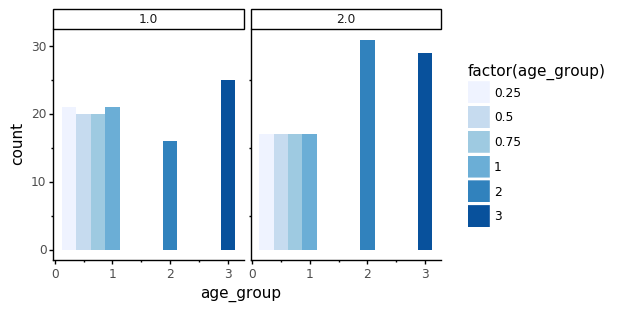

<ggplot: (160787361039)>

In [38]:
gg.options.figure_size = (5, 3)
g = (gg.ggplot(all_data, gg.aes('age_group', fill='factor(age_group)'))
#  + gg.geom_histogram(bin=0.25)
 + gg.stat_bin(binwidth=0.25)
 + gg.facet_grid('~ Gender')
 + gg.scale_fill_brewer()
)
g.save(os.path.join(plot_save_path, '0AgegroupHistogram.png'))
g

## Distributions of all features

In [39]:
# Histograms and 
# for feature in all_data.columns:
#     g = (gg.ggplot(all_data, gg.aes(feature))
#          + gg.geom_histogram()
#         )
#     g.save(os.path.join(plot_save_path, '0hist_{}.png'.format(feature)))
    
#     g = (gg.ggplot(all_data, gg.aes('PreciseYrs', feature))
#          + gg.geom_point()
#          + gg.geom_smooth()
#         )
#     g.save(os.path.join(plot_save_path, '0age_{}.png'.format(feature)))
# g

In [40]:
# gg.options.figure_size = (20, 20)

# # Pretty, but too slow to work
# g = (gg.ggplot(all_data_long, gg.aes('value'))
#      + gg.geom_histogram()
#      + gg.facet_wrap('~ feature', scales='free')
#     )
# g

# Ugly, but fast and works
# for feature in all_data.columns:
#     g = (gg.ggplot(all_data, gg.aes(feature))
#          + gg.geom_histogram()
#         )
#     g.save(os.path.join(plot_save_path, '0hist_{}.png'.format(feature)))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\0feature_means.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


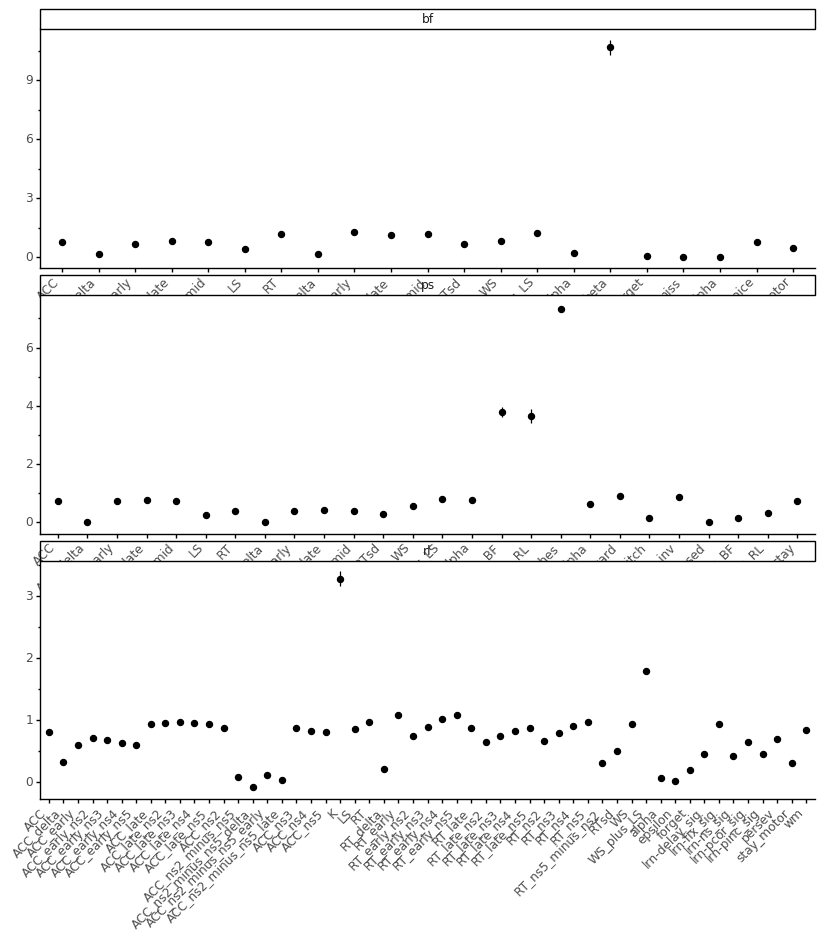

<ggplot: (116240564516)>

In [259]:
# Mean of each feature
gg.options.figure_size = (10, 10)
g = (gg.ggplot(all_data_long, gg.aes('param', 'value'))
     + gg.stat_summary()
#      + gg.geom_violin()
     + gg.labs(x='', y='')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
     + gg.facet_wrap('~ task', scales='free', ncol=1)
    )
g.save(os.path.join(plot_save_path, '0feature_means.png'))
g

## Features over age

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20 x 20 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2age_feature_separate.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 13 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20 x 20 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 513 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


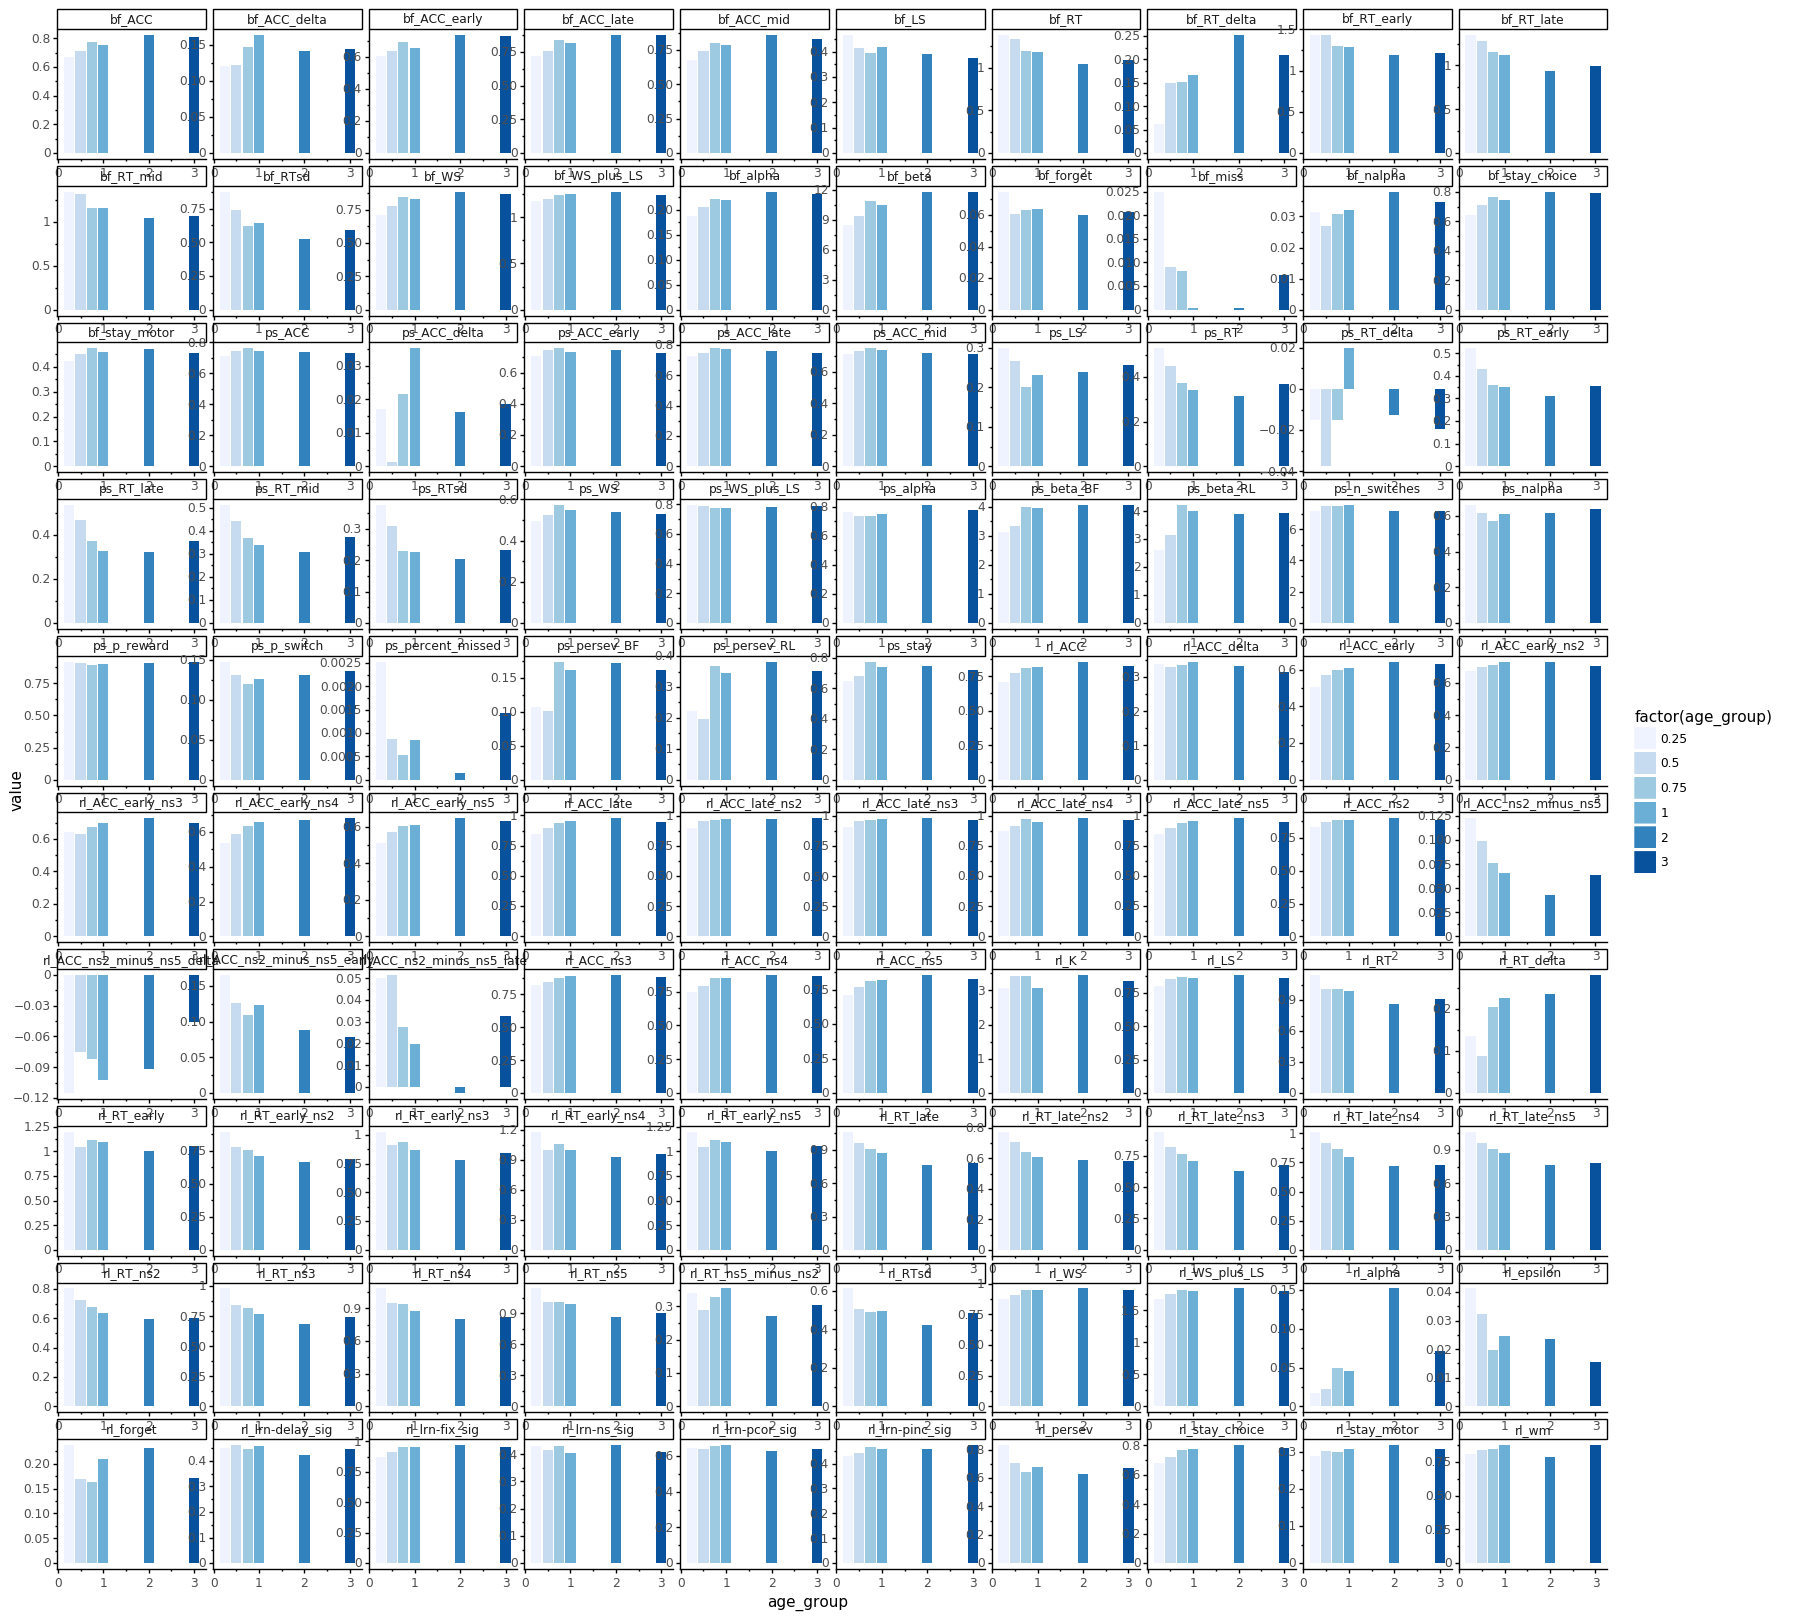

(<ggplot: (160789321960)>, <ggplot: (160671768794)>)

In [41]:
# Each feature over age
gg.options.figure_size = (20, 20)
g = (gg.ggplot(all_data_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
 + gg.geom_point(size=0.5, alpha=0.5)
 + gg.geom_smooth()
 + gg.labs(y='')
 + gg.facet_wrap('~ feature', scales='free')
)
g.save(os.path.join(plot_save_path, '2age_feature_separate.png'))

g_pds = g + gg.aes('PDS')
g_pds.save(os.path.join(plot_save_path, '2PDS_feature_separate.png'))
g_t = g + gg.aes('meanT')
g_t.save(os.path.join(plot_save_path, '2T_feature_separate.png'))

# Each feature over age group
g2 = (gg.ggplot(all_data_long, gg.aes('age_group', 'value', fill='factor(age_group)'))
 + gg.stat_summary(geom='bar')
 + gg.scale_fill_brewer()
 + gg.facet_wrap('~ feature', scales='free')
)
g2.save(os.path.join(plot_save_path, '2agegroup_feature.png'))

g, g2

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2age_feature.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2age_feature_z.png
  warn('Filename: {}'.format(filename), Plotn

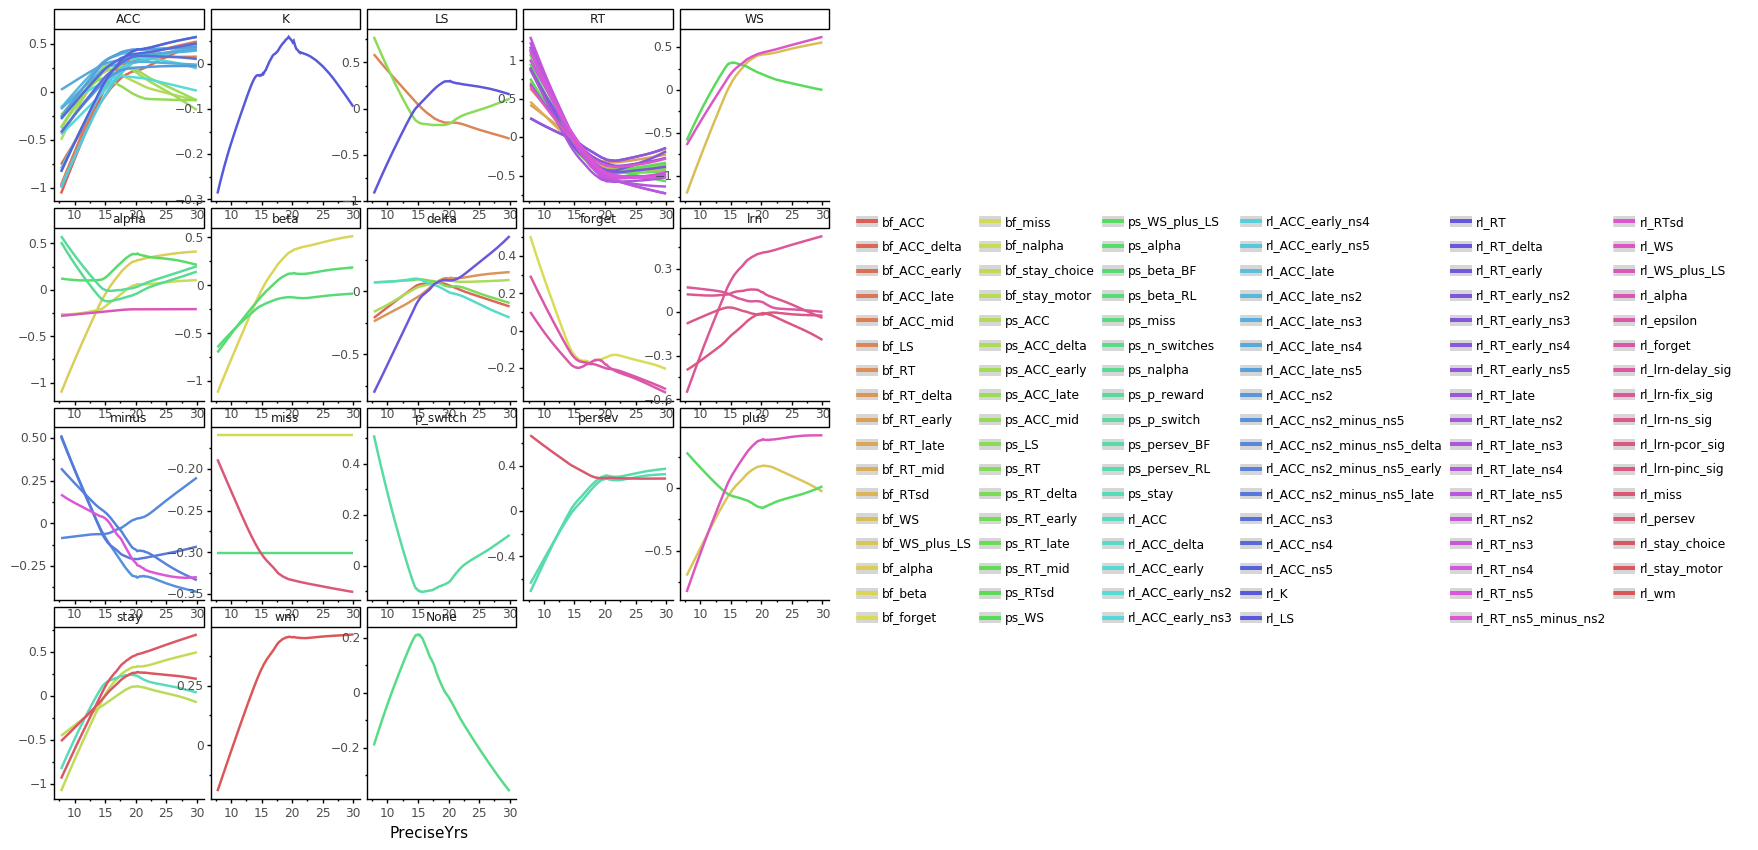

<ggplot: (160681937128)>

In [100]:
# Group features
gg.options.figure_size = (10, 10)
g = (gg.ggplot(
    all_data_long,#[all_data_long.category == 'lrn'],
    gg.aes('PreciseYrs', 'value', color='feature'))
#  + gg.geom_point(size=0.5, alpha=0.5)
 + gg.labs(y='', color='')
 + gg.geom_smooth()
 + gg.facet_wrap('~ category', scales='free')
)
g.save(os.path.join(plot_save_path, '2age_feature.png'))

g_z = g
g_z.data = all_data_long_z
g.save(os.path.join(plot_save_path, '2age_feature_z.png'))

g

# Dimensionality reduction (PCA)

In [101]:
# Run PCA
def run_pca(pca_dat):
    
    pca = PCA(n_components=pca_dat.shape[1])
    # pca = KernelPCA(n_components=z_dat.shape[1])
    fit = pca.fit_transform(pca_dat)
    
    return pca, fit

# Run PCA on all data
ids_all = all_data_z.drop(columns=ages_cols[1:] + ['age_group']).dropna().ID
pca_dat_all = all_data_z.drop(columns=ages_cols + ['age_group']).dropna()
pca_all, fit_all = run_pca(pca_dat_all)

# Run PCA on behavior only
param_cols = []
for col in all_data_z.columns:
    for param_name in param_names:
        if param_name in col:
            param_cols += [col]

ids_beh = all_data_z.drop(columns=ages_cols[1:] + ['age_group'] + param_cols).dropna().ID
pca_dat_beh = all_data_z.drop(columns=ages_cols + ['age_group'] + param_cols).dropna()
pca_beh, fit_beh = run_pca(pca_dat_beh)

# Run PCA on params only
ids_par = all_data_z[param_cols + ['ID']].dropna().ID
pca_dat_par = all_data_z[param_cols].dropna()
pca_par, fit_par = run_pca(pca_dat_par)

Explained variance at 20 components: 83.9%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCAExplVar_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


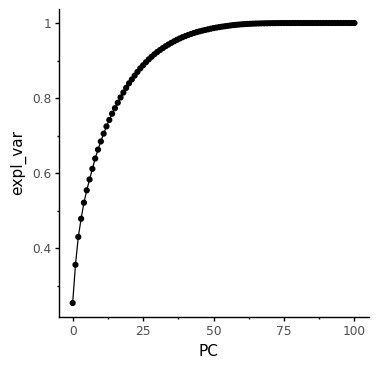

<ggplot: (-9223371876183080188)>
Explained variance at 20 components: 88.7%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCAExplVar_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


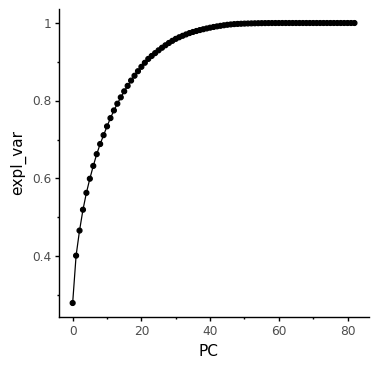

<ggplot: (-9223371876184393230)>
Explained variance at 20 components: 100.0%.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCAExplVar_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


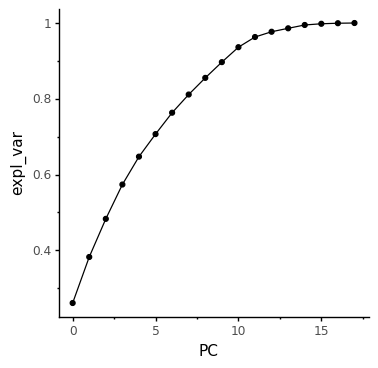

<ggplot: (160671814948)>


In [102]:
# Plot explained variance
def plot_expl_var(pca_dat, pca, name):
    
    n_comp = 20
    expl_var_dat = pd.DataFrame({'PC': range(pca_dat.shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
    expl_var_at_n_comp = list(expl_var_dat[expl_var_dat.PC <= n_comp].expl_var)[-1]
    print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))

    g = (gg.ggplot(expl_var_dat, gg.aes('PC', 'expl_var'))
     + gg.geom_point()
     + gg.geom_line()
#      + gg.geom_hline(yintercept=1, linetype='dashed')
#      + gg.geom_hline(yintercept=expl_var_at_n_comp, linetype='dotted')
#      + gg.geom_vline(xintercept=n_comp, linetype='dotted')
    )
    g.save(os.path.join(plot_save_path, '5PCAExplVar_{}.png'.format(name)))
    print(g)
    
# Explained variance all behaviors
gg.options.figure_size = (4, 4)
plot_expl_var(pca_dat_all, pca_all, 'all')
plot_expl_var(pca_dat_beh, pca_beh, 'beh')
plot_expl_var(pca_dat_par, pca_par, 'par')

In [103]:
def create_fit_pd(fit, pca_dat, ids, ages_sub, n_comp=9):
    
    # fit_pd
    fit_pd = pd.DataFrame(fit,
                          columns=['pc{}'.format(i) for i in range(pca_dat.shape[1])],
                          index=ids)
    fit_pd = fit_pd.reset_index()
    fit_pd = fit_pd.merge(ages_sub)
    
    # fit_long
    fit_pd_long = fit_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=ages_cols)

    return fit_pd, fit_pd_long

# Create fit_pd's
ages_sub = ages[ages_cols]
fit_pd_all, fit_pd_long_all = create_fit_pd(fit_all, pca_dat_all, ids_all, ages_sub)
fit_pd_beh, fit_pd_long_beh = create_fit_pd(fit_beh, pca_dat_beh, ids_beh, ages_sub)
fit_pd_par, fit_pd_long_par = create_fit_pd(fit_par, pca_dat_par, ids_par, ages_sub)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC0PC1_Age_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC2PC3_Age_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\P

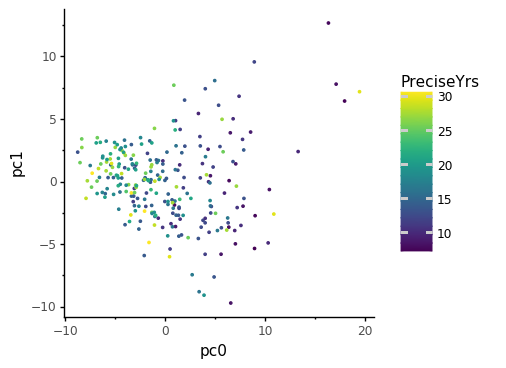

<ggplot: (-9223371876183024324)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC0PC1_Age_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC2PC3_Age_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\P

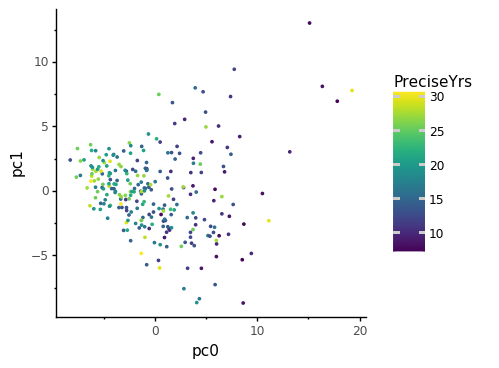

<ggplot: (-9223371876190069581)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC0PC1_Age_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PC2PC3_Age_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\P

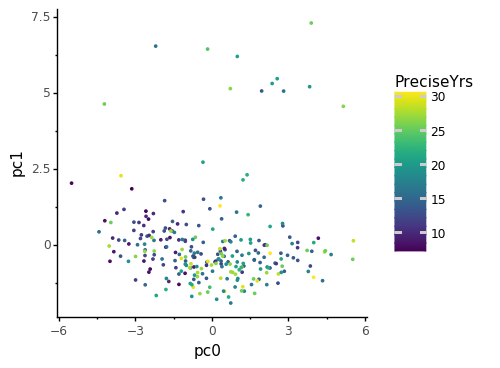

<ggplot: (-9223371876182935783)>


In [104]:
# Age in PC space
def plot_age_in_pc_space(fit_pd, name):
    
    g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
     + gg.geom_point(size=0.5)
    )
    g1.save(os.path.join(plot_save_path, '5PC0PC1_Age_{}.png'.format(name)))

    g2 = g1 + gg.aes('pc2', 'pc3')
    g2.save(os.path.join(plot_save_path, '5PC2PC3_Age_{}.png'.format(name)))
    
    g3 = g1 + gg.aes(color='PDS')
    g3.save(os.path.join(plot_save_path, '5PC0PC1_PDS_{}.png'.format(name)))

    g4 = g1 + gg.aes(color='meanT')
    g4.save(os.path.join(plot_save_path, '5PC0PC1_T_{}.png'.format(name)))
    
    print(g1)

# Run on all measures
plot_age_in_pc_space(fit_pd_all, 'all')
plot_age_in_pc_space(fit_pd_beh, 'beh')
plot_age_in_pc_space(fit_pd_par, 'par')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_Age_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


<ggplot: (160682246562)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_T_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothing

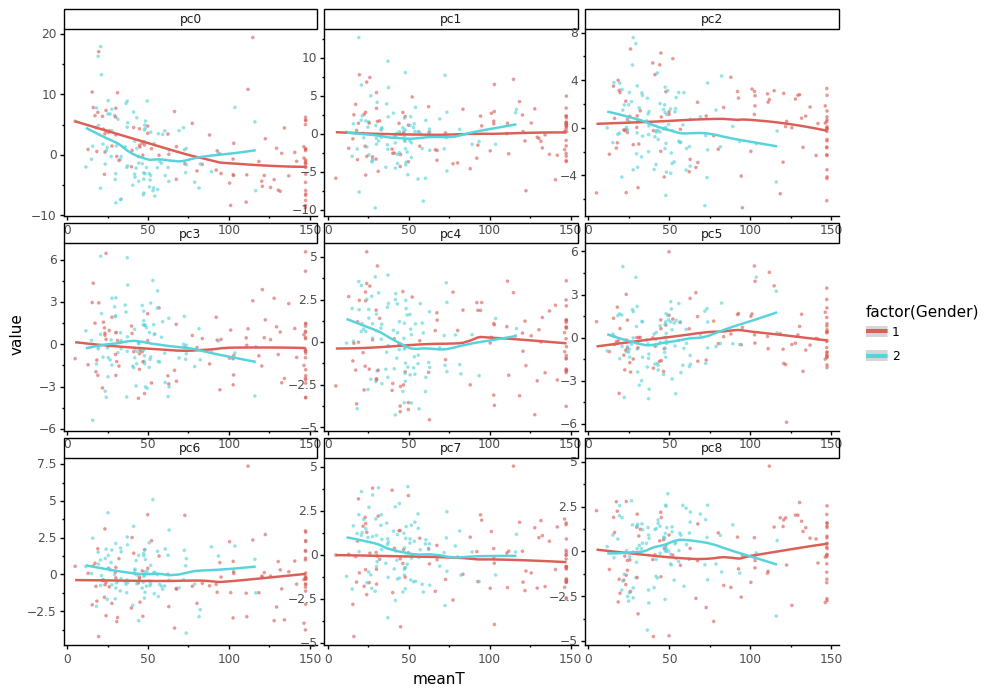

<ggplot: (-9223371876186373460)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_PDS_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 954 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothi

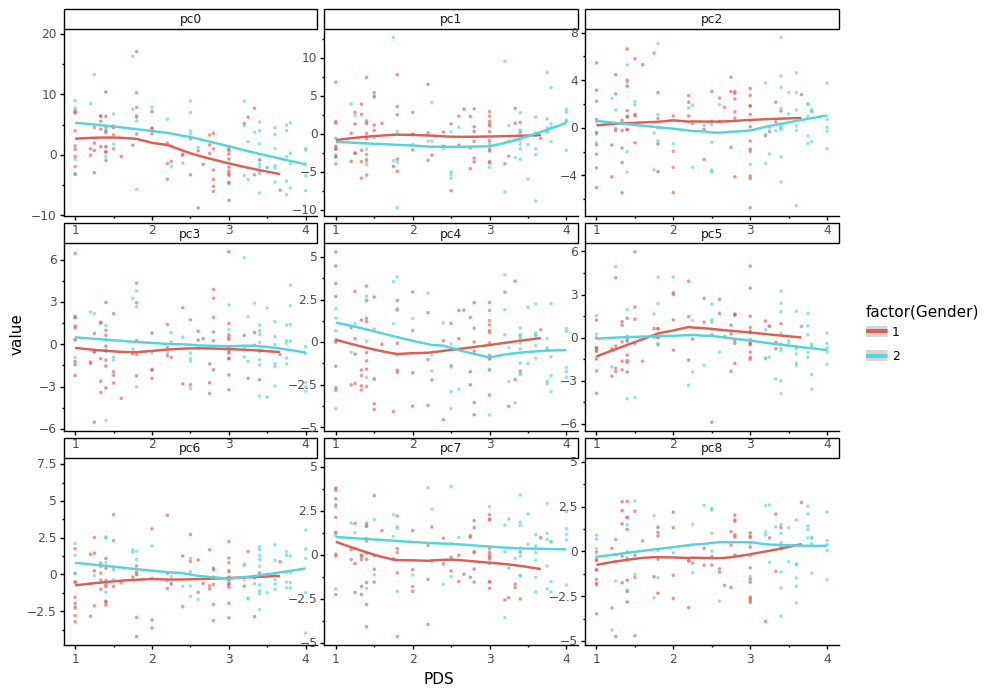

<ggplot: (160673085581)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_Age_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


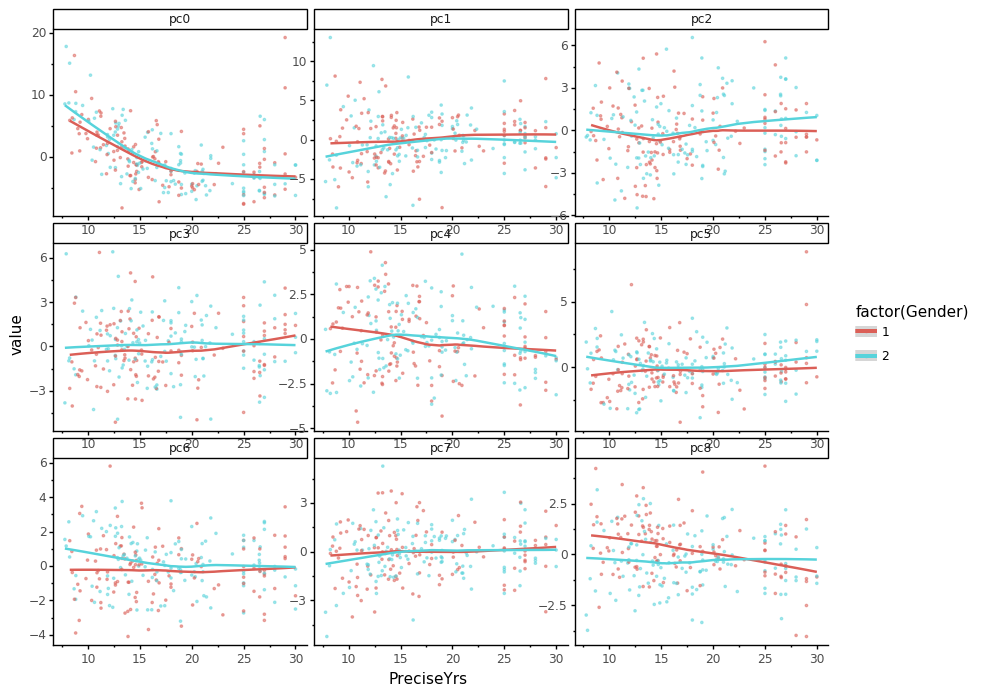

<ggplot: (160680150434)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_T_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothing

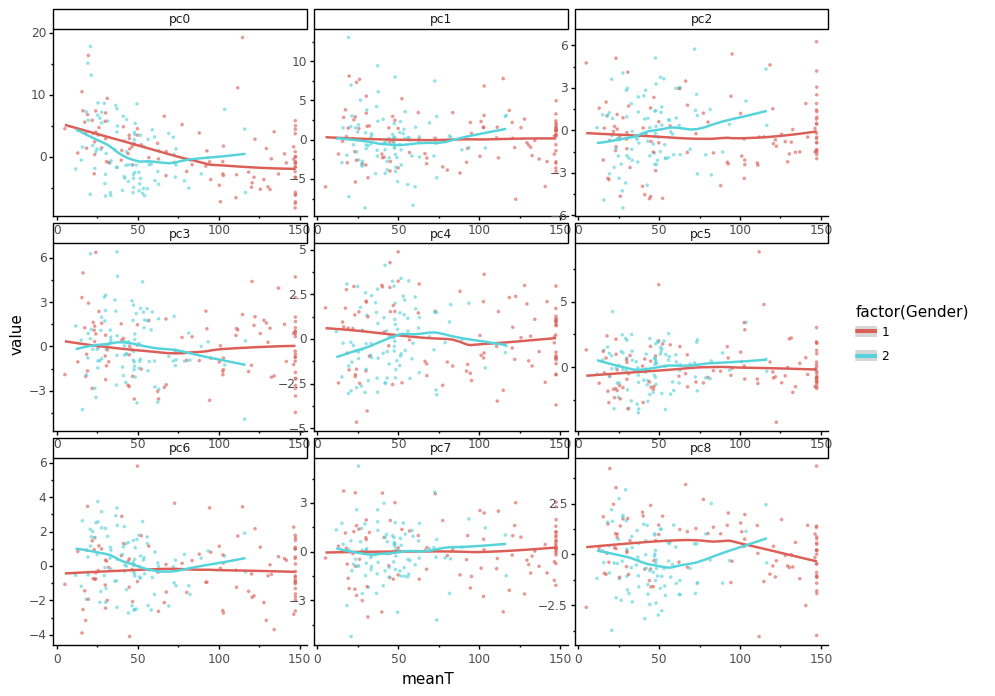

<ggplot: (160670355534)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_PDS_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 954 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothi

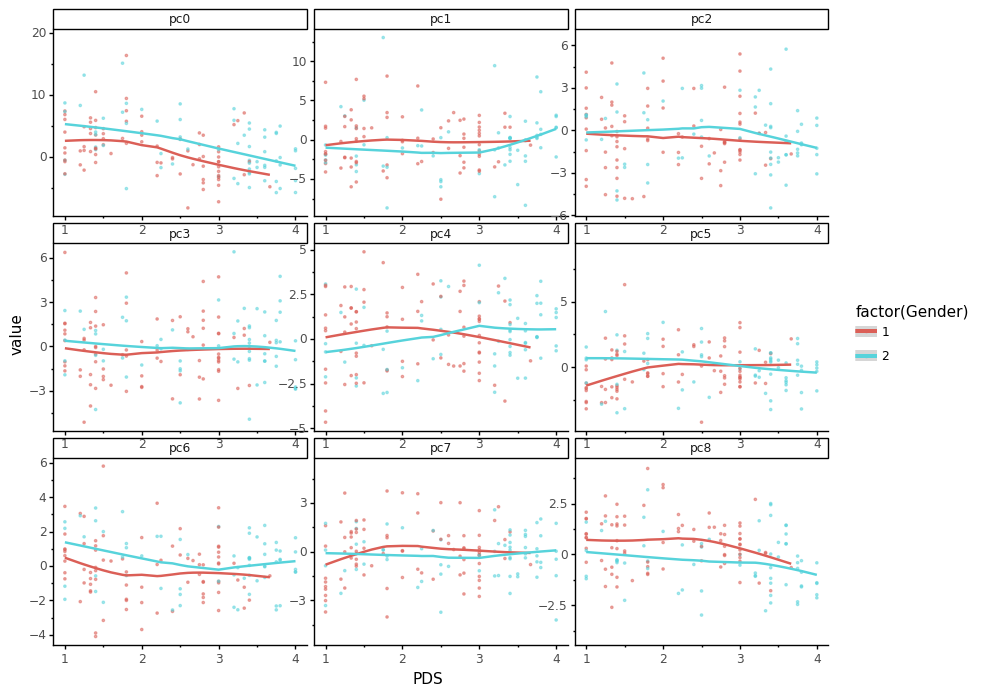

<ggplot: (-9223371876183029181)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_Age_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


<ggplot: (-9223371876174514414)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_T_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 531 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothing

<ggplot: (-9223371876174017511)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCA_PDS_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 972 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothi

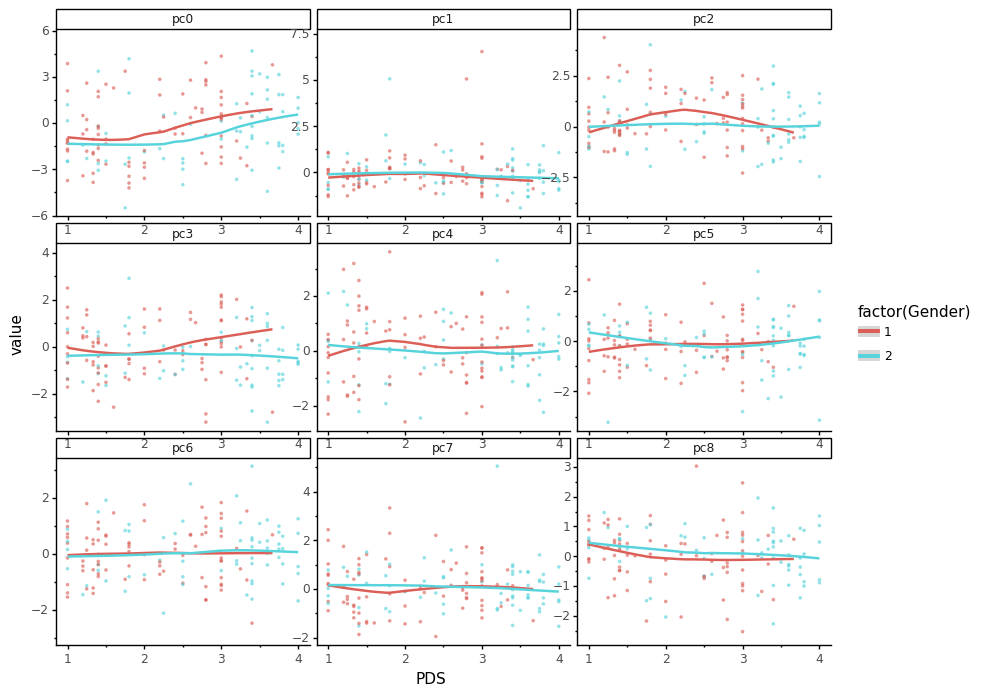

<ggplot: (160789357260)>


In [105]:
# PC changes over age
def plot_pcs_over_age(fit_pd_long, name):
    
    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(fit_pd_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
     + gg.geom_point(alpha=0.5, size=0.5)
     + gg.geom_smooth()
     + gg.facet_wrap('~ variable', scales='free')
    )
    g.save(os.path.join(plot_save_path, '5PCA_Age_{}.png'.format(name)))
    print(g)
    
    g_t = g + gg.aes(x='meanT')
    g_t.save(os.path.join(plot_save_path, '5PCA_T_{}.png'.format(name)))
    print(g_t)
    
    g_pds = g + gg.aes(x='PDS')
    g_pds.save(os.path.join(plot_save_path, '5PCA_PDS_{}.png'.format(name)))
    print(g_pds)
    
# Plot all
plot_pcs_over_age(fit_pd_long_all, 'all')
plot_pcs_over_age(fit_pd_long_beh, 'beh')
plot_pcs_over_age(fit_pd_long_par, 'par')

In [106]:
# Factor loadings
def create_loadings_long(pca, pca_dat, n_comp=10):
    
    loadings = pca.components_[:n_comp].T  # (n_components, n_features)  * np.sqrt(pca.explained_variance_)
    loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=pca_dat.columns)
    loadings_pd = loadings_pd.reset_index()
    loadings_long = loadings_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['index'])
    
    loadings_long['task'] = loadings_long['index'].apply(lambda x : x[:2])
    loadings_long['ACC_RT'] = loadings_long['index'].apply(name_from_index, names=['ACC', 'RT'])
    loadings_long['category'] = loadings_long['index'].apply(name_from_index, names=category_cols)
    loadings_long['param_bool'] = loadings_long['index'].apply(bool_from_index, names=param_cols)
    loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[2:]))

    for param in choice_param_cols:
        loadings_long.loc[loadings_long['index'] == param, 'category'] = 'choice'
    for param in update_param_cols:
        loadings_long.loc[loadings_long['index'] == param, 'category'] = 'update'
    
    loadings_long.loc[loadings_long['index'].isin(wsls_cols), 'category'] = 'WSLS'
    
    return loadings_long

# All
loadings_long_all = create_loadings_long(pca_all, pca_dat_all)
loadings_long_beh = create_loadings_long(pca_beh, pca_dat_beh)
loadings_long_par = create_loadings_long(pca_par, pca_dat_par)

In [107]:
minus_is = [i for i in list(set(loadings_long_beh['index'])) if 'minus' in i]
loadings_long_all.loc[loadings_long_all['category'].isin(['choice', 'update'])]

index variable     value task ACC_RT category  param_bool  PC
14     bf_alpha      pc0 -0.110597   bf   None   update        True   0
15    bf_nalpha      pc0 -0.030752   bf   None   update        True   0
16      bf_beta      pc0 -0.129971   bf   None   choice        True   0
17    bf_forget      pc0  0.086222   bf   None   choice        True   0
59     rl_alpha      pc0 -0.043845   rl   None   update        True   0
..          ...      ...       ...  ...    ...      ...         ...  ..
972  rl_epsilon      pc9  0.076758   rl   None   choice        True   9
979  ps_beta_BF      pc9  0.043976   ps   None   choice        True   9
983    ps_alpha      pc9 -0.035249   ps   None   update        True   9
984  ps_beta_RL      pc9  0.025573   ps   None   choice        True   9
985   ps_nalpha      pc9  0.068647   ps   None   update        True   9

[110 rows x 8 columns]

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCALoadings_all_beh_only.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


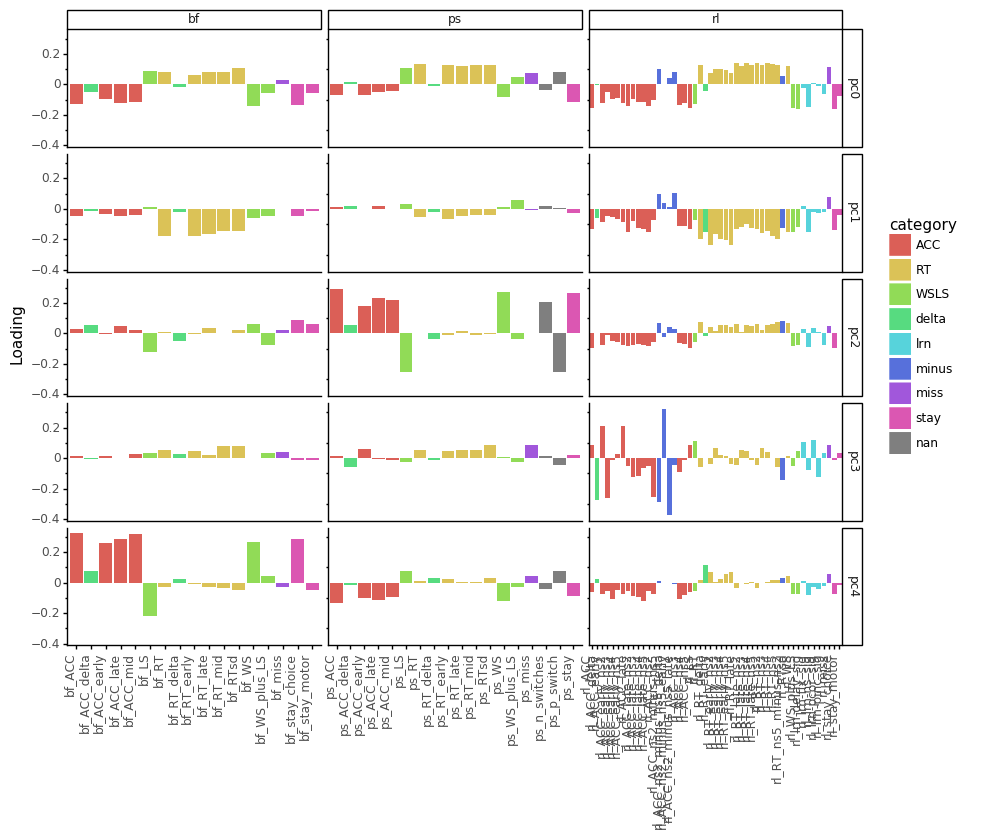

<ggplot: (-9223371876183012941)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCALoadings_all_par_only.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


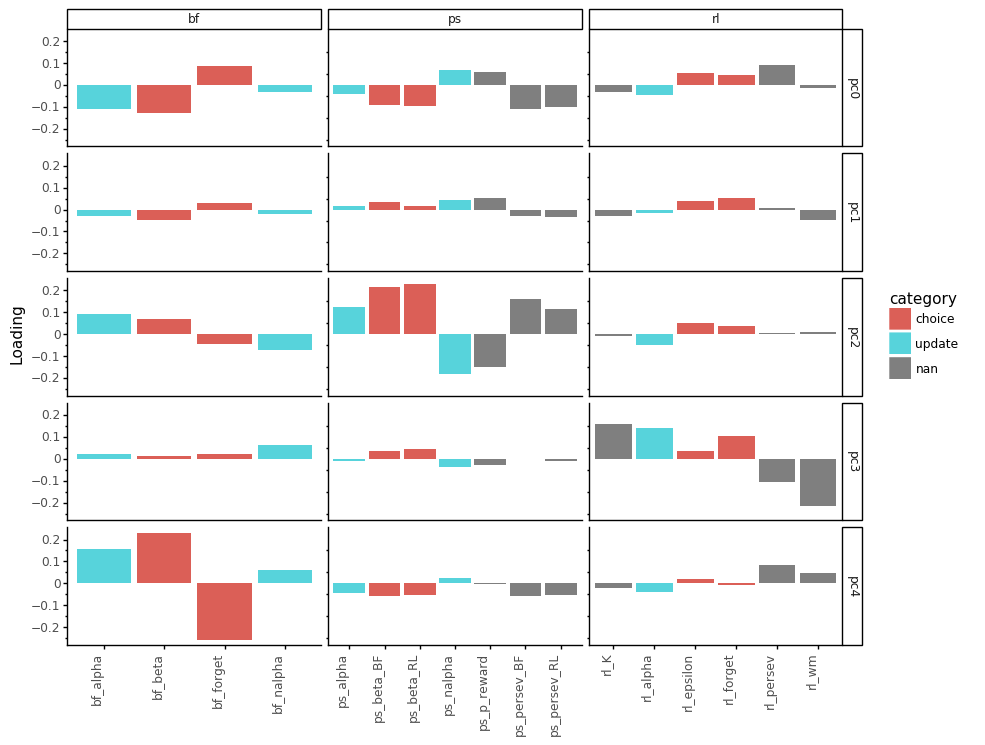

<ggplot: (-9223371876193227043)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCALoadings_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


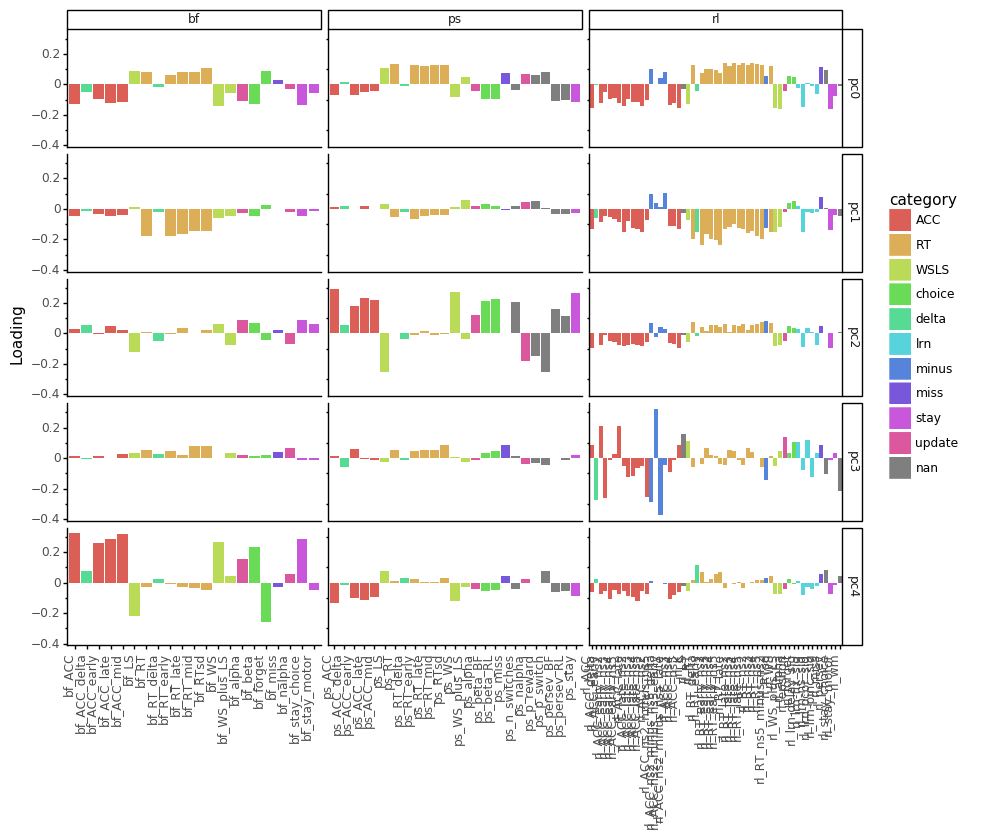

<ggplot: (160671860274)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCALoadings_beh.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


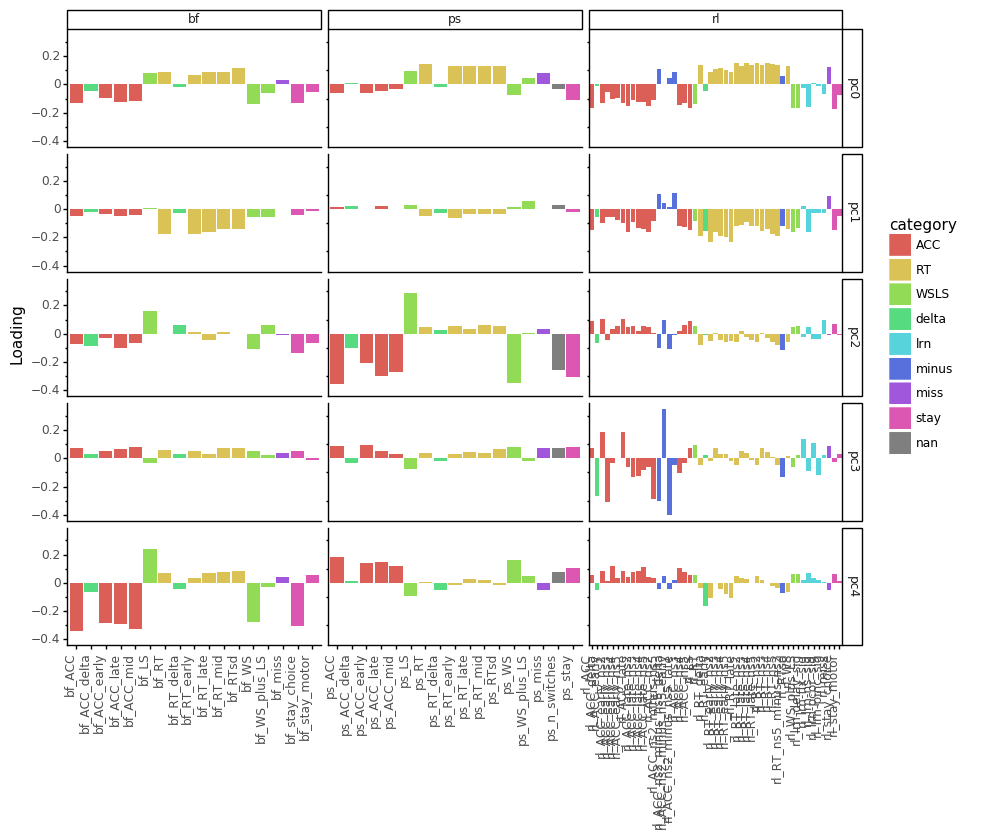

<ggplot: (-9223371876172777086)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5PCALoadings_par.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


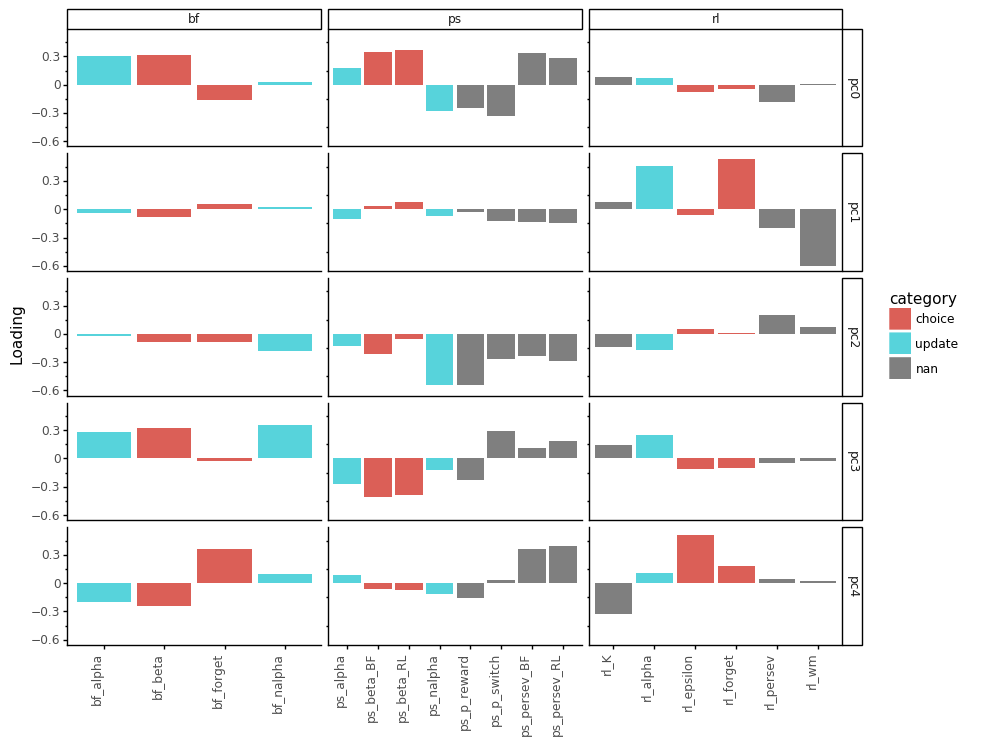

<ggplot: (160668282965)>


In [108]:
def plot_loadings(loadings_long, name, n_comp=5):

    if name == 'all_beh_only':
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & np.invert(loadings_long['param_bool'])]
    elif name == 'all_par_only':
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & (loadings_long['param_bool'])]
    else:
        sub_dat = loadings_long[loadings_long['PC'] < n_comp]

    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(sub_dat, gg.aes('index', 'value', fill='category'))
     + gg.geom_bar(stat='identity')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
     + gg.facet_grid('variable ~ task', scales='free_x')
     + gg.labs(x='', y='Loading')
    )
    g.save(os.path.join(plot_save_path, '5PCALoadings_{}.png'.format(name)))
    print(g)
    
# Plot
plot_loadings(loadings_long_all, 'all_beh_only')
plot_loadings(loadings_long_all, 'all_par_only')
plot_loadings(loadings_long_all, 'all')
plot_loadings(loadings_long_beh, 'beh')
plot_loadings(loadings_long_par, 'par')

In [109]:
# loadings_pd['param_name'] = loadings_pd['index'].apply(lambda x : x[3:])
# loadings_pd['param_bool'] = loadings_pd['index'].apply(lambda x : x[:2])
# loadings_pd['category'] = loadings_pd['param_name'].apply(name_from_index, names=param_names + category_cols)
# loadings_pd['ACC_RT'] = loadings_pd['param_name'].apply(name_from_index, names=['ACC', 'RT'])
# loadings_pd['task'] = loadings_pd['index'].apply(lambda x: x[:2])
# loadings_pd

In [110]:
# loadings_long['index'].sort()
# loadings_long = loadings_long.reindex(sorted(loadings_long.columns), axis=1)
# loadings_long = loadings_long.reindex(sorted(loadings_long['index']), axis=0)
# loadings_long

In [111]:
# temp = list(set(loadings_long['category'].to_list()))
# temp2 = [t for t in temp if t != None]
# temp2.sort()
# temp2

## Regularized regression

### Ridge regression
* L2-norm (returns small but non-zero coefficients)
* It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high #features, say in millions, as it will pose computational challenges.
* It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

### Lasso regression
* L1-norm (sparse; tries to get many coefficients 0)
* It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.
* Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases where the #features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.

### Conclusion
* Ridge might be better because of how it deals with correlated features

In [309]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

In [428]:
# Get regression data
regr_data_name = 'pc'  # can be 'raw' or 'pc'

if regr_data_name == 'raw':
    regr_dat = all_data_z[[c for c in wanted_cols if c not in ages_cols[2:] + ['age_group']]]  # behaviors
elif regr_data_name == 'pc':
    regr_dat = pd.merge(fit_pd_all, ages).drop(columns=[c for c in ages.columns if (c != 'ID') and (c != 'PreciseYrs')])  # PCs
else:
    raise(ValueError)

regr_dat = regr_dat.dropna().set_index('ID')
regr_y = regr_dat['PreciseYrs']
regr_X = regr_dat.drop(columns='PreciseYrs')

In [429]:
regr_y

ID
17      8.657084
18     12.637919
19     12.637919
20     14.543463
22     16.490075
         ...    
465    22.333333
466    20.083333
467    18.750000
468    21.833333
469    19.000000
Name: PreciseYrs, Length: 253, dtype: float64

In [430]:
regr_X

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
ID                                                                          
17   7.005208 -4.977855 -3.730538 -1.010815 -0.105105  2.345603  1.097027   
18  -1.894974 -0.915344  1.886922  0.149340 -0.746307  1.194606 -0.153467   
19  -2.960420  1.320744  2.855317 -5.529766 -0.704136  4.162398 -2.135938   
20  -5.199214  0.320077  2.892936  3.884962 -0.534997 -1.791990 -0.178721   
22   0.952571 -1.558160 -1.094971 -0.483910 -0.938626 -1.374364  1.113587   
..        ...       ...       ...       ...       ...       ...       ...   
465 -2.888323  1.463021 -0.072574  1.082980 -1.607345 -1.879753  1.459184   
466 -4.700989  1.857288  1.356228  1.699448 -3.904617  1.344229 -0.868716   
467  1.775180 -2.700194 -2.885153  3.098669  0.066638 -1.350545  1.325149   
468 -0.972225 -2.700205 -1.668597  4.630448 -2.696922 -2.929367  3.491732   
469  0.260544 -1.593603  0.327250 -0.393424  0.010729  2.493943  0.577120   

          pc7       pc8       pc9  ...          pc91          pc92  \
ID                                 ...                               
17  -1.232193  2.298029  0.648192  ...  1.111650e-15 -1.925746e-16   
18   2.586629 -1.176611 -0.818119  ...  5.860338e-16  5.778026e-16   
19   1.774392 -0.551401 -0.693733  ... -6.254142e-17  2.137678e-17   
20  -1.550401  1.758457 -2.850784  ... -4.436956e-16  6.002342e-16   
22  -1.526032 -2.631802  1.124015  ...  2.994320e-16  4.224572e-16   
..        ...       ...       ...  ...           ...           ...   
465  0.187775 -1.433479 -1.700930  ...  3.136271e-17 -2.547797e-16   
466  0.083888  2.628549  3.810458  ... -2.407593e-16  2.976849e-16   
467 -0.418256  1.526467 -0.188179  ...  2.242715e-16  8.201977e-17   
468 -2.781161 -3.785179  3.719529  ... -1.974128e-16  1.289227e-16   
469 -0.165170 -0.681281 -0.471761  ... -2.244013e-16  3.104770e-16   

             pc93          pc94          pc95          pc96          pc97  \
ID                                                                          
17   1.521751e-15 -7.155983e-16 -3.960795e-16 -3.136035e-17 -1.727745e-16   
18  -4.355024e-16 -7.366774e-16  2.420160e-15  3.476947e-16 -8.226258e-16   
19   5.212712e-16  3.517944e-16 -1.295963e-16 -3.120444e-17 -1.493901e-16   
20  -2.054705e-16 -6.596272e-16 -5.048658e-16  5.659408e-17 -3.601954e-16   
22  -8.096311e-16  9.961180e-16  1.464229e-16  4.826120e-16 -4.832053e-16   
..            ...           ...           ...           ...           ...   
465 -1.082575e-16  1.237308e-16 -1.755501e-16  5.358705e-17 -3.324239e-16   
466  1.824331e-16  4.722251e-17 -7.100042e-17  1.911298e-16  3.889341e-18   
467  2.832151e-16  5.091231e-17  2.065983e-16  2.760530e-17 -1.854197e-16   
468  1.998790e-16 -8.516716e-17  8.772973e-17  7.246614e-18 -1.787824e-16   
469  8.412348e-18 -9.513319e-17 -3.540388e-17  2.746586e-16  1.429400e-16   

             pc98          pc99         pc100  
ID                                             
17  -7.765016e-16 -1.796901e-16 -7.105502e-16  
18   2.906989e-16  3.522960e-16 -7.266342e-16  
19   3.120323e-17  1.516887e-16 -6.121569e-16  
20   7.438583e-16  1.979417e-16  7.507186e-16  
22  -5.146575e-16  8.518290e-16 -2.931836e-17  
..            ...           ...           ...  
465 -1.043852e-16  2.820716e-17 -5.050566e-16  
466  2.952644e-16 -3.121056e-16  3.672313e-16  
467  2.407198e-16 -3.793541e-16  1.229411e-16  
468 -2.554609e-18  3.440182e-16  1.275141e-16  
469 -2.401678e-17 -7.223495e-16  1.798084e-16  

[253 rows x 101 columns]

In [439]:
# Run simple linear regression on all basic features
reg = LinearRegression().fit(regr_X, regr_y)
reg = Ridge(alpha=0.8).fit(regr_X, regr_y)

lin_reg_result = pd.DataFrame(
    reg.coef_, [c for c in regr_dat.columns if c != 'PreciseYrs']).reset_index().rename(
    columns={'index': 'predictor', 0: 'coef'})
lin_reg_result

predictor          coef
0         pc0 -5.619592e-01
1         pc1  1.304282e-01
2         pc2 -3.238123e-01
3         pc3  1.185972e-01
4         pc4  3.022092e-01
..        ...           ...
96       pc96 -3.449542e-14
97       pc97 -4.229639e-14
98       pc98 -2.181408e-14
99       pc99 -3.089181e-15
100     pc100  1.972564e-14

[101 rows x 2 columns]

In [440]:
if regr_data_name == 'raw':
    # Sort predictors by coefficient value (for plotting)
    lin_reg_result = lin_reg_result.sort_values(by='coef')
    lin_reg_result = lin_reg_result.reset_index(drop=True)
    lin_reg_result['predictor_cat'] = pd.Categorical(lin_reg_result['predictor'], categories=lin_reg_result['predictor'])

    # Add columns
    lin_reg_result['category'] = lin_reg_result['predictor'].apply(name_from_index, names=category_cols)
    lin_reg_result['task'] = lin_reg_result.predictor.apply(lambda x : x[:2])

elif regr_data_name == 'pc':
    # Add columns
    lin_reg_result['predictor_cat'] = lin_reg_result['predictor'].apply(lambda x : int(x[2:]))
    lin_reg_result['task'] = lin_reg_result.predictor.apply(lambda x : x[:2])
    lin_reg_result['category'] = lin_reg_result.predictor.apply(lambda x : x[:2])

In [441]:
# Performance of this model
pred_y = reg.predict(regr_X)

linregr_true_pred = pd.DataFrame(np.array([np.array(regr_y), pred_y]).T, columns=('true_y', 'pred_y'))
gg.options.figure_size = (6, 6)
g = (gg.ggplot(linregr_true_pred, gg.aes('true_y', 'pred_y'))
 + gg.geom_point()
 + gg.labs(x='True age', y='Predicted age')
)
g.save(os.path.join(plot_save_path, '2Regr_lin_perf_{}.png'.format('')))
print(g)

print("R2: {:.2f}".format(r2_score(regr_y, pred_y)))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2Regr_lin_perf_.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


<ggplot: (-9223371876174509666)>
R2: 0.62


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2Regr_lin_task_.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


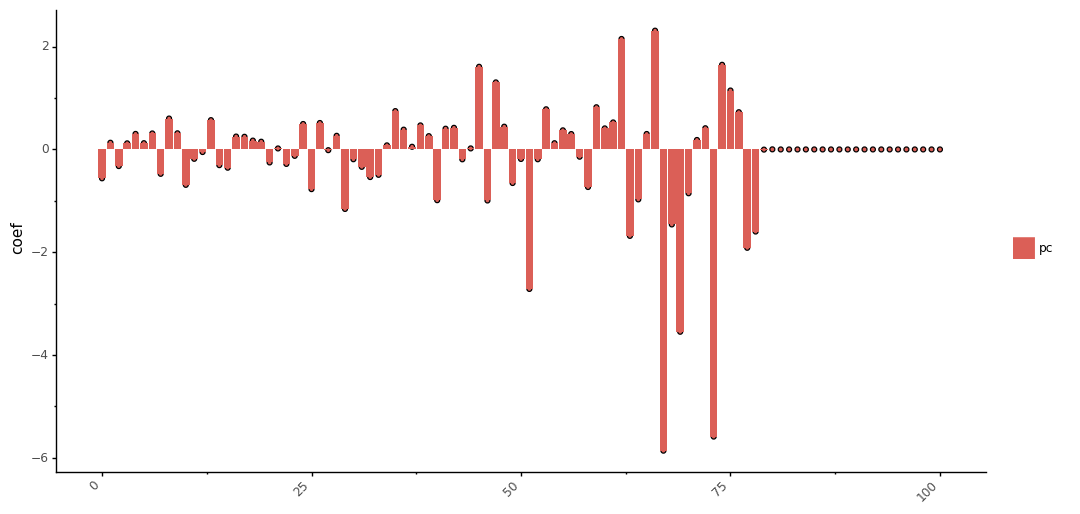

<ggplot: (160682069375)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2Regr_lin__cat_.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


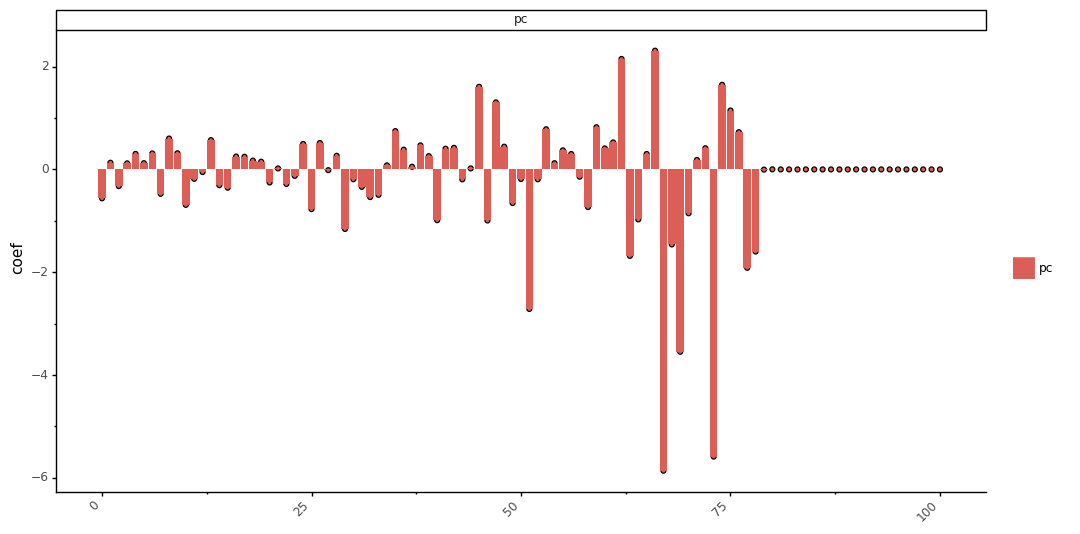

<ggplot: (-9223371876183031990)>


In [442]:
gg.options.figure_size = (12, 6)
g = (gg.ggplot(lin_reg_result, gg.aes('predictor_cat', 'coef', fill='task'))
 + gg.geom_point()
 + gg.geom_bar(stat='identity')
 + gg.labs(x='', fill='')
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)
g.save(os.path.join(plot_save_path, '2Regr_lin_task_{}.png'.format('')))
print(g)

g2 = g + gg.facet_grid('~ category', scales='free_x')
g2
g2.save(os.path.join(plot_save_path, '2Regr_lin__cat_{}.png'.format('')))
print(g2)

In [142]:
poly = PolynomialFeatures(2)
regr_poly = poly.fit_transform(regr_X)
regr_poly = pd.DataFrame(regr_poly, columns=poly.get_feature_names(regr_dat.columns))
regr_poly = regr_poly.set_index(regr_dat.index)
regr_poly

1  PreciseYrs    bf_ACC     bf_RT   bf_RTsd  bf_ACC_delta  bf_RT_delta  \
ID                                                                              
17   1.0   -1.316224  0.404685  0.131150 -2.967827     -1.096424     -0.15991   
18   1.0    0.243251  0.003448 -0.389745  1.500825     -0.672216     -0.15991   
19   1.0   -1.761817 -0.978544 -1.418655 -0.893096     -0.493225     -0.15991   
20   1.0    0.577429 -0.543333 -0.423068  1.022041      0.426350     -0.15991   
22   1.0   -0.202342  0.892565  1.194143  0.224067     -0.543845     -0.15991   
..   ...         ...       ...       ...       ...           ...          ...   
465  1.0   -0.146601 -0.205097 -0.415410  0.862446      0.637317     -0.15991   
466  1.0   -1.037787 -0.861671 -1.055200 -0.733501     -0.120424     -0.15991   
467  1.0    0.243251  0.274857  0.557898 -1.212285      0.631336     -0.15991   
468  1.0   -0.313690  2.556550  2.793854 -1.052690      1.805641     -0.15991   
469  1.0   -0.202342 -0.150159 -0.220027 -0.733501      0.082695     -0.15991   

      bf_miss     bf_WS     bf_LS  ...  ps_p_reward^2  ps_p_reward ps_alpha  \
ID                                 ...                                        
17  -0.616940  0.302522 -0.337602  ...       0.000019             -0.005123   
18   0.140131 -0.612816 -0.553128  ...       0.895712              0.010264   
19   1.221712 -2.750954 -1.822303  ...       0.446474             -0.337449   
20   0.707320 -0.162155  0.600838  ...       0.652899              3.019308   
22  -0.108312  2.085330  2.293071  ...       0.230903             -0.466558   
..        ...       ...       ...  ...            ...                   ...   
465 -0.030208  1.500472  1.703156  ...       0.133451              0.281833   
466 -0.184308 -0.626764 -0.930965  ...       0.981100              1.696901   
467  0.107160  1.231876  1.545391  ...       0.000261             -0.000138   
468 -0.164483  2.515206  2.728042  ...       0.166333             -0.099675   
469 -0.090597 -0.273872 -0.418013  ...       1.312052             -0.995516   

     ps_p_reward ps_beta_RL  ps_p_reward ps_nalpha  ps_alpha^2  \
ID                                                               
17                 0.005833              -0.005776    1.351348   
18                 0.888091              -0.246334    0.000118   
19                 0.915191               0.128913    0.255047   
20                -0.293990               0.581595   13.962679   
22                -0.194454               0.126041    0.942716   
..                      ...                    ...         ...   
465                0.008173               0.390547    0.595200   
466               -0.536275              -0.395740    2.934942   
467                0.017736              -0.007834    0.000073   
468                0.078140               0.541336    0.059731   
469               -1.029116               1.433246    0.755346   

     ps_alpha ps_beta_RL  ps_alpha ps_nalpha  ps_beta_RL^2  \
ID                                                           
17             -1.538495            1.523548      1.751559   
18              0.010177           -0.002823      0.880534   
19             -0.691710           -0.097434      1.875976   
20             -1.359547            2.689566      0.132379   
22              0.392910           -0.254676      0.163759   
..                   ...                 ...           ...   
465             0.017260            0.824791      0.000500   
466            -0.927536           -0.684468      0.293131   
467            -0.009370            0.004138      1.204600   
468            -0.046825           -0.324397      0.036709   
469             0.780839           -1.087472      0.807193   

     ps_beta_RL ps_nalpha  ps_nalpha^2  
ID                                      
17              -1.734542     1.717690  
18              -0.244238     0.067746  
19               0.264249     0.037222  
20              -0.261883     0.518079  
22           

In [132]:
tuned_parameters = [{'alpha': [1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'max_iter': [1e5]}]

ridge_grid = GridSearchCV(linear_model.Ridge(), tuned_parameters, scoring='r2', cv=3, iid=False, return_train_score=False)
ridge_best = ridge_grid.fit(regr_X, regr_y)
print(pd.DataFrame(ridge_best.cv_results_).sort_values(by='rank_test_score').head())

ridge_best.best_params_

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
11       0.002327  4.697412e-04         0.000998        0.000815           1   
10       0.002992  7.786718e-07         0.000997        0.000814         0.9   
9        0.003325  4.697979e-04         0.001329        0.000940         0.8   
8        0.005650  4.687024e-04         0.001996        0.001413         0.7   
7        0.002992  8.152702e-04         0.001663        0.000940         0.6   

   param_max_iter                                params  split0_test_score  \
11         100000    {'alpha': 1, 'max_iter': 100000.0}          -5.122791   
10         100000  {'alpha': 0.9, 'max_iter': 100000.0}          -5.138431   
9          100000  {'alpha': 0.8, 'max_iter': 100000.0}          -5.156959   
8          100000  {'alpha': 0.7, 'max_iter': 100000.0}          -5.179157   
7          100000  {'alpha': 0.6, 'max_iter': 100000.0}          -5.206105   

    split1_test_score  split2_test_score  mean_tes

{'alpha': 1, 'max_iter': 100000.0}

In [133]:
# ridge = linear_model.Ridge(alpha=ridge_best.best_params_['alpha'])
ridge = linear_model.Ridge(alpha=0.5)
ridge.fit(regr_X, regr_y)
ridge.coef_, ridge.intercept_
dat = pd.DataFrame(ridge.coef_, index=poly.get_feature_names()).reset_index()
dat = dat.rename(columns={0: 'coef'})

(gg.ggplot(dat.loc[dat.coef != 0], gg.aes('index', 'coef'))
 + gg.geom_point()
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)

ValueError: Shape of passed values is (59, 1), indices imply (1830, 1)

Train score: 0.2684717252934875
Test score: 0.19147512205276596
[0.34865875 0.17071859 0.3988524  0.24906931 0.31345949]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


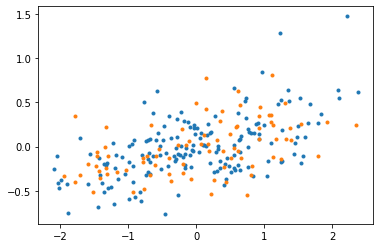

In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.33, random_state=42)

Train score: 0.5888578188890606
Test score: -1.4242368850812452
[-2.08192147 -1.207382   -2.86767432 -1.65034001 -0.96360785]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


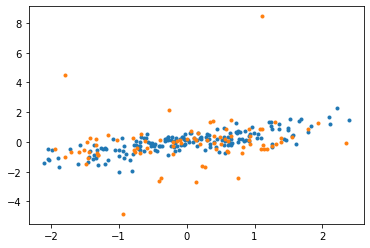

In [240]:
ridge = ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print("Train score: {}".format(ridge.score(X_train, y_train)))
print("Test score: {}".format(ridge.score(X_test, y_test)))
print(cross_val_score(ridge, X_test, y_test, cv=5))
print(cross_val_score(ridge, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [237]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names())
X_poly

1        x0        x1        x2        x3        x4        x5  \
0    1.0 -0.293752 -0.245033  0.710701 -0.021864  0.706793  0.705310   
1    1.0  0.765410 -0.257551  0.378495 -0.110525  0.188962  0.171465   
2    1.0 -1.352913 -0.241354  0.710701 -1.145188 -0.594605  0.426715   
3    1.0  1.824571 -0.258110  0.167463 -0.566927 -0.781397  0.805723   
4    1.0 -0.293752 -0.264741  0.276161 -0.422234  0.439665  0.333127   
..   ...       ...       ...       ...       ...       ...       ...   
251  1.0 -0.293752 -0.146479  0.710701 -0.133701  0.247793  0.152600   
252  1.0  1.824571  2.744729 -3.272954  2.286169 -0.125842 -0.924643   
253  1.0  1.824571 -0.272958 -0.144806 -0.063319  0.192876 -0.078255   
254  1.0  1.824571  5.070012  0.265920  0.165366  1.503186 -2.414981   
255  1.0  1.824571 -0.289426 -0.132794  0.169124 -0.714175  0.939700   

           x6        x7        x8  ...     x10^2   x10 x11   x10 x12  \
0   -1.314424 -1.162475 -1.310607  ...  0.000019  0.005833 -0.006773   
1   -0.360931 -0.010845  0.260280  ...  0.895712  0.888091 -0.752812   
2    0.075406  0.505022 -0.192930  ...  0.446474  0.915191 -0.898690   
3    3.125907  3.736667  0.719777  ...  0.652899 -0.293990  1.478530   
4   -1.200251 -0.970936  0.262299  ...  0.230903 -0.194454 -0.305453   
..        ...       ...       ...  ...       ...       ...       ...   
251  0.941097  0.771492  1.069086  ...  0.133451  0.008173  0.167029   
252  1.688176  1.713167 -0.399533  ...  0.981100 -0.536275  1.404209   
253  0.434027 -0.008537 -0.484772  ...  0.000261  0.017736 -0.003515   
254  0.501182 -0.244399  1.327326  ...  0.166333  0.078140 -0.464810   
255 -0.776400 -0.869106  1.251254  ...  1.312052 -1.029116 -1.241425   

      x10 x13     x11^2   x11 x12   x11 x13     x12^2   x12 x13     x13^2  
0    0.004315  1.751559 -2.033821  1.295885  2.361570 -1.504715  0.958755  
1    1.091803  0.880534 -0.746406  1.082513  0.632710 -0.917619  1.330822  
2    0.794403  1.875976 -1.842151  1.628381  1.808936 -1.599021  1.413464  
3    0.294305  0.132379 -0.665759 -0.132521  3.348220  0.666472  0.132663  
4   -0.259763  0.163759  0.257237  0.218758  0.404073  0.343631  0.292230  
..        ...       ...       ...       ...       ...       ...       ...  
251  0.037131  0.000500  0.010229  0.002274  0.209056  0.046473  0.010331  
252  0.342689  0.293131 -0.767549 -0.187316  2.009787  0.490477  0.119698  
253  0.017983  1.204600 -0.238719  1.221435  0.047308 -0.242056  1.238505  
254  0.234853  0.036709 -0.218358  0.110329  1.298889 -0.656285  0.331599  
255 -1.185173  0.807193  0.973720  0.929598  1.174601  1.121376  1.070564  

[256 rows x 120 columns]

In [260]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x0 x13',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x1 x11',
 'x1 x12',
 'x1 x13',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x2 x11',
 'x2 x12',
 'x2 x13',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x3 x8',
 'x3 x9',
 'x3 x10',
 'x3 x11',
 'x3 x12',
 'x3 x13',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x4 x8',
 'x4 x9',
 'x4 x10',
 'x4 x11',
 'x4 x12',
 'x4 x13',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x8',
 'x5 x9',
 'x5 x10',
 'x5 x11',
 'x5 x12',
 'x5 x13',
 'x6^2',
 'x6 x7',
 'x6 x8',
 'x6 x9',
 'x6 x10',
 'x6 x11',
 'x6 x12',
 'x6 x13',
 'x7^2',
 'x7 x8',
 'x7 x9',
 'x7 x10',
 'x7 x11',
 'x7 x12',
 'x7 x13',
 'x8^2',
 'x8 x9',
 'x8 x10'

In [245]:
from sklearn.pipeline import make_pipeline

def PolynomialLasso(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         linear_model.Lasso(**kwargs))

In [253]:
tuned_parameters = {
    'polynomialfeatures__degree': np.arange(4),
    'lasso__alpha': [0.01, 0.1, 0.3, 0.5],
    'lasso__max_iter': [1e5],
}

lasso_grid = GridSearchCV(PolynomialLasso(), tuned_parameters, scoring='r2', cv=3, iid=False, return_train_score=False)
lasso_best = lasso_grid.fit(X_poly, y)
print(pd.DataFrame(lasso_best.cv_results_).sort_values(by='rank_test_score').head())

lasso_best.best_params_

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objectiv

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.010306      0.004179         0.002658        0.000940   
9       0.007315      0.002860         0.002327        0.000471   
0       0.005982      0.000816         0.001664        0.000469   
4       0.011304      0.010344         0.002326        0.000470   
8       0.019282      0.022336         0.001663        0.000470   

  param_lasso__alpha param_lasso__max_iter param_polynomialfeatures__degree  \
5                0.1                100000                                1   
9                0.3                100000                                1   
0               0.01                100000                                0   
4                0.1                100000                                0   
8                0.3                100000                                0   

                                              params  split0_test_score  \
5  {'lasso__alpha': 0.1, 'lasso__max_iter': 100

{'lasso__alpha': 0.1,
 'lasso__max_iter': 100000.0,
 'polynomialfeatures__degree': 1}

In [243]:
tuned_parameters = [{'alpha': [1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'max_iter': [1e5]}]

lasso_grid = GridSearchCV(linear_model.Lasso(), tuned_parameters, scoring='r2', cv=3, iid=False, return_train_score=False)
lasso_best = lasso_grid.fit(X_poly, y)
print(pd.DataFrame(lasso_best.cv_results_).sort_values(by='rank_test_score').head())

lasso_best.best_params_

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
2       0.003324      0.001245         0.000998    4.899036e-07         0.1   
3       0.003020      0.000003         0.001311    4.830051e-04         0.2   
4       0.002651      0.000481         0.000990    1.215233e-05         0.3   
5       0.003666      0.000477         0.001663    4.681114e-04         0.4   
6       0.002650      0.000463         0.001346    4.579245e-04         0.5   

  param_max_iter                                params  split0_test_score  \
2         100000  {'alpha': 0.1, 'max_iter': 100000.0}           0.059840   
3         100000  {'alpha': 0.2, 'max_iter': 100000.0}          -0.023420   
4         100000  {'alpha': 0.3, 'max_iter': 100000.0}          -0.089546   
5         100000  {'alpha': 0.4, 'max_iter': 100000.0}          -0.126327   
6         100000  {'alpha': 0.5, 'max_iter': 100000.0}          -0.126327   

   split1_test_score  split2_test_score  mean_test_score  std_

{'alpha': 0.1, 'max_iter': 100000.0}

In [244]:
ridge_grid = GridSearchCV(linear_model.Ridge(), tuned_parameters, scoring='r2', cv=3, iid=False, return_train_score=False)
ridge_best = ridge_grid.fit(X_poly, y)
print(pd.DataFrame(ridge_best.cv_results_).sort_values(by='rank_test_score').head())

ridge_best.best_params_

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
11       0.002659      0.000471         0.001662    9.397623e-04           1   
10       0.003325      0.000470         0.001332    4.733372e-04         0.9   
9        0.004654      0.000471         0.001995    8.131292e-04         0.8   
8        0.003989      0.000003         0.001662    4.686798e-04         0.7   
7        0.003989      0.000002         0.000996    7.370010e-07         0.6   

   param_max_iter                                params  split0_test_score  \
11         100000    {'alpha': 1, 'max_iter': 100000.0}          -0.770553   
10         100000  {'alpha': 0.9, 'max_iter': 100000.0}          -0.823907   
9          100000  {'alpha': 0.8, 'max_iter': 100000.0}          -0.885821   
8          100000  {'alpha': 0.7, 'max_iter': 100000.0}          -0.958835   
7          100000  {'alpha': 0.6, 'max_iter': 100000.0}          -1.046697   

    split1_test_score  split2_test_score  mean_tes

{'alpha': 1, 'max_iter': 100000.0}

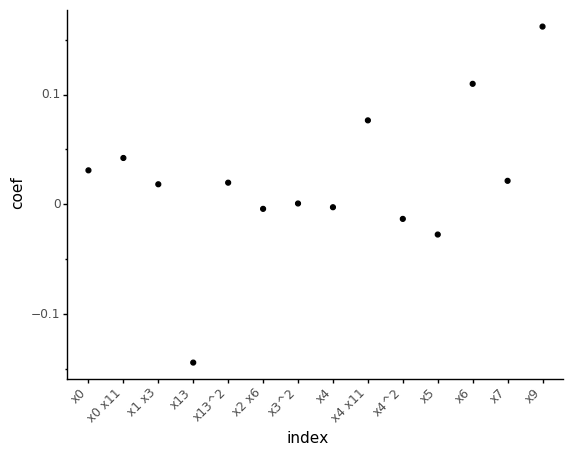

<ggplot: (-9223371927327505513)>

In [232]:
lasso = linear_model.Lasso(alpha=lasso_best.best_params_['alpha'])
lasso.fit(X_poly, y)
lasso.coef_, lasso.intercept_
dat = pd.DataFrame(lasso.coef_, index=poly.get_feature_names()).reset_index()
dat = dat.rename(columns={0: 'coef'})

(gg.ggplot(dat.loc[dat.coef != 0], gg.aes('index', 'coef'))
 + gg.geom_point()
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)

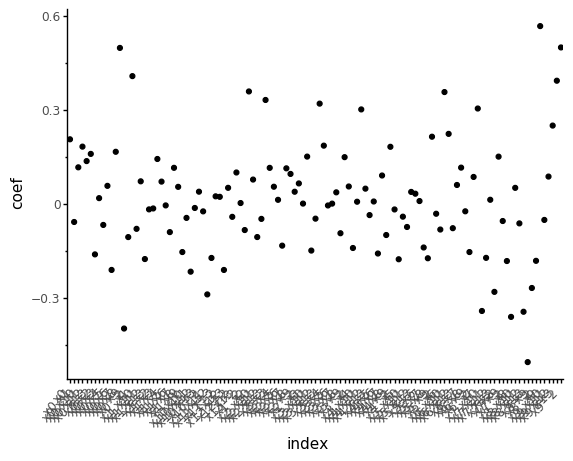

<ggplot: (-9223371927322920430)>

In [239]:
ridge = linear_model.Ridge(alpha=ridge_best.best_params_['alpha'])
ridge.fit(X_poly, y)
ridge.coef_, ridge.intercept_
dat = pd.DataFrame(ridge.coef_, index=poly.get_feature_names()).reset_index()
dat = dat.rename(columns={0: 'coef'})

(gg.ggplot(dat.loc[dat.coef != 0], gg.aes('index', 'coef'))
 + gg.geom_point()
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)

Train score: 0.2684717252934875
Test score: 0.19147512205276596
[0.34865875 0.17071859 0.3988524  0.24906931 0.31345949]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


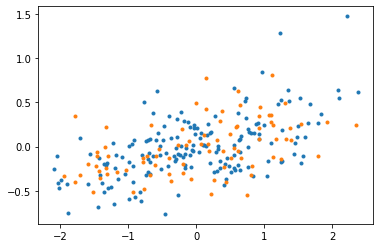

In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.33, random_state=42)

lasso = lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print("Train score: {}".format(lasso.score(X_train, y_train)))
print("Test score: {}".format(lasso.score(X_test, y_test)))
print(cross_val_score(lasso, X_test, y_test, cv=5))
print(cross_val_score(lasso, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

Train score: 0.5888578188890606
Test score: -1.4242368850812452
[-2.08192147 -1.207382   -2.86767432 -1.65034001 -0.96360785]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


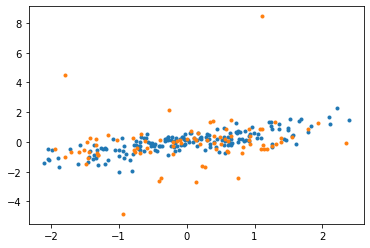

In [240]:
ridge = ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print("Train score: {}".format(ridge.score(X_train, y_train)))
print("Test score: {}".format(ridge.score(X_test, y_test)))
print(cross_val_score(ridge, X_test, y_test, cv=5))
print(cross_val_score(ridge, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

# SVM

In [30]:
all_data_z[param_cols_by_task]

bf_alpha  bf_nalpha   bf_beta  bf_forget      rl_K  rl_alpha     rl_wm  \
0   -0.741288  -0.268582 -1.033575   1.942240 -0.293752 -0.245033  0.710701   
1   -0.742421  -1.065820 -0.116430  -0.882096  0.765410 -0.257551  0.378495   
2    2.384159  -2.188693  1.998333  -1.478335 -1.352913 -0.241354  0.710701   
3   -0.393261   0.263324  0.354709  -0.722190  1.824571 -0.258110  0.167463   
4   -1.186291   2.924170  0.353369   0.193834 -0.293752 -0.264741  0.276161   
..        ...        ...       ...        ...       ...       ...       ...   
251 -0.675806   1.078762 -0.363157  -0.174755 -0.293752 -0.146479  0.710701   
252  1.649813  -1.292193  0.267250   1.582144  1.824571  2.744729 -3.272954   
253 -0.098707   1.068968 -0.058794   0.571948  1.824571 -0.272958 -0.144806   
254 -0.017591   3.446940  1.207517   2.164332  1.824571  5.070012  0.265920   
255 -0.042741  -0.996893 -0.618330  -0.225710  1.824571 -0.289426 -0.132794   

     rl_forget  rl_epsilon  rl_persev  ps_beta_BF  ps_beta_RL  ps_persev_RL  \
0    -0.021864    0.706793   0.705310   -1.314424   -1.162475     -1.310607   
1    -0.110525    0.188962   0.171465   -0.360931   -0.010845      0.260280   
2    -1.145188   -0.594605   0.426715    0.075406    0.505022     -0.192930   
3    -0.566927   -0.781397   0.805723    3.125907    3.736667      0.719777   
4    -0.422234    0.439665   0.333127   -1.200251   -0.970936      0.262299   
..         ...         ...        ...         ...         ...           ...   
251  -0.133701    0.247793   0.152600    0.941097    0.771492      1.069086   
252   2.286169   -0.125842  -0.924643    1.688176    1.713167     -0.399533   
253  -0.063319    0.192876  -0.078255    0.434027   -0.008537     -0.484772   
254   0.165366    1.503186  -2.414981    0.501182   -0.244399      1.327326   
255   0.169124   -0.714175   0.939700   -0.776400   -0.869106      1.251254   

     ps_persev_BF  ps_alpha  ps_nalpha  ps_p_switch_inv  ps_p_reward  
0       -1.557762  0.004407   1.323465        -1.536740     0.979161  
1        0.213482 -0.946421  -0.938368         0.795430    -1.153613  
2        0.054378 -0.668187  -1.369663         1.344967    -1.188892  
3        0.958514  0.808022  -0.363840         1.829814     0.364229  
4        0.111252  0.480524  -0.404671        -0.635668    -0.540583  
..            ...       ...        ...              ...          ...  
251      1.084878  0.365310   0.022372         0.457226     0.101641  
252     -0.295515  0.990505  -0.541416         1.417669     0.345974  
253     -0.360511  0.016159   1.097543        -0.217504     1.112882  
254      1.423852  0.407839   0.191595        -1.139688     0.575846  
255      1.064372  1.145448  -0.898439        -1.083790    -1.034680  

[256 rows x 18 columns]

In [58]:
X, y

(         rl_K  rl_alpha     rl_wm  rl_forget  rl_epsilon  rl_persev  \
 0   -0.293752 -0.245033  0.710701  -0.021864    0.706793   0.705310   
 1    0.765410 -0.257551  0.378495  -0.110525    0.188962   0.171465   
 2   -1.352913 -0.241354  0.710701  -1.145188   -0.594605   0.426715   
 3    1.824571 -0.258110  0.167463  -0.566927   -0.781397   0.805723   
 4   -0.293752 -0.264741  0.276161  -0.422234    0.439665   0.333127   
 ..        ...       ...       ...        ...         ...        ...   
 251 -0.293752 -0.146479  0.710701  -0.133701    0.247793   0.152600   
 252  1.824571  2.744729 -3.272954   2.286169   -0.125842  -0.924643   
 253  1.824571 -0.272958 -0.144806  -0.063319    0.192876  -0.078255   
 254  1.824571  5.070012  0.265920   0.165366    1.503186  -2.414981   
 255  1.824571 -0.289426 -0.132794   0.169124   -0.714175   0.939700   
 
      ps_beta_BF  ps_beta_RL  ps_persev_RL  ps_persev_BF  ps_alpha  ps_nalpha  \
 0     -1.314424   -1.162475     -1.310607     -1.557

bf_nalpha ~ ['rl_K', 'rl_alpha', 'rl_wm', 'rl_forget', 'rl_epsilon', 'rl_persev', 'ps_beta_BF', 'ps_beta_RL', 'ps_persev_RL', 'ps_persev_BF', 'ps_alpha', 'ps_nalpha', 'ps_p_switch_inv', 'ps_p_reward']
[LibSVM]Train score: 0.9901380630262752
Test score: -23.613846474859745
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][-2.66654928 -4.28549182 -9.62246189 -2.52619833 -0.78734739]
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][

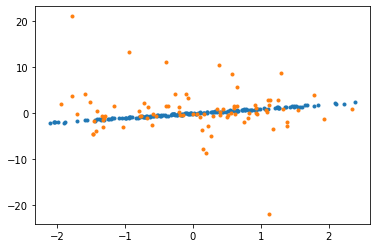

In [98]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_param = 'bf_nalpha'  # 'bf_alpha'
print(y_param, '~', x_params)

X = all_data_z[x_params]
y = all_data_z['bf_alpha']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

svr = svm.SVR(kernel='poly', C=1e4, gamma='scale', degree=3, epsilon=.1, verbose=True)
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [135]:
tuned_parameters = [
    {'kernel': ['rbf', 'poly'],
     'C': [1e-1, 1e1, 1e2, 1e3, 1e4],
     'gamma': [1e-5, 1e-4, 1e-4, 1e-3, 1e-2, 1e-1]}]

clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='r2', cv=2, iid=False, return_train_score=False)
clf_fit = clf.fit(X, y)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())

# clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='explained_variance', cv=2, iid=False, return_train_score=False)
# clf_fit = clf.fit(X_train, y_train)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())
clf_fit.best_params_

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Train score: 0.38118042326010027
Test score: 0.35633285985363083
[ 0.12162177 -0.44621745  0.43552897  0.42128234  0.39269335]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


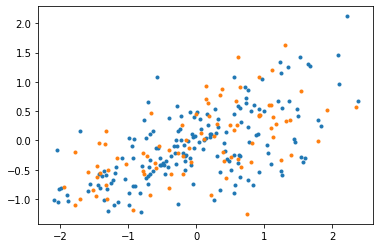

In [141]:

svr = svm.SVR(C=clf_fit.best_params_['C'], gamma=clf_fit.best_params_['gamma'], kernel=clf_fit.best_params_['kernel'])
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [92]:
from sklearn.model_selection import GridSearchCV

# param_grid = {'polynomialfeatures__degree': np.arange(21),
#               'linearregression__fit_intercept': [True, False],
#               'linearregression__normalize': [True, False]}

# grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)



tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

clf = GridSearchCV(
    svm.SVC(), tuned_parameters, scoring=scores[0]
)
clf.fit(X_train, y_train)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Unknown label type: 'continuous'

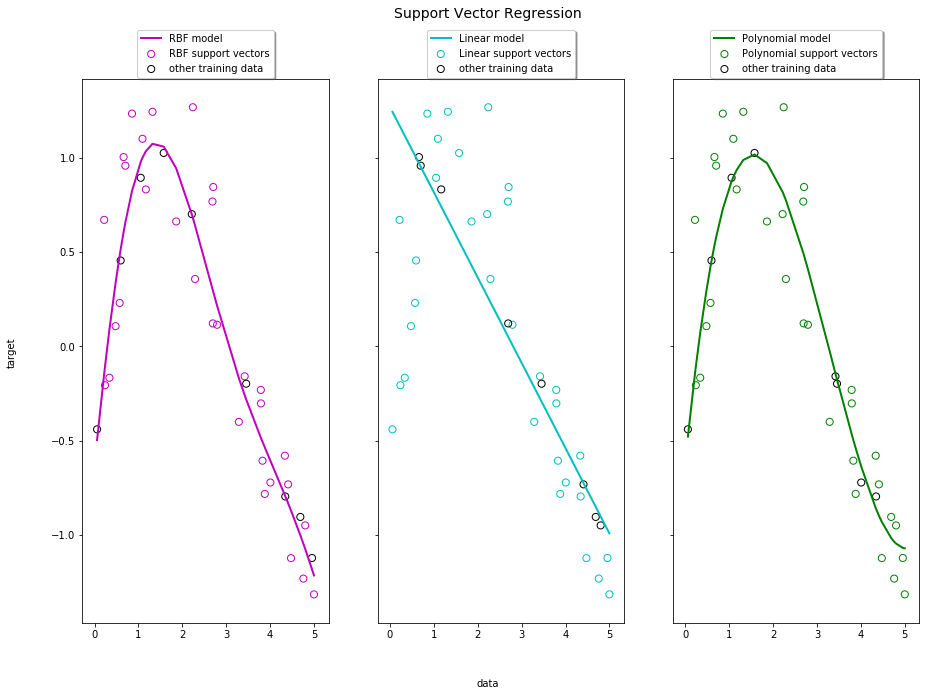

In [8]:
# import numpy as np
# from sklearn.svm import SVR
# import matplotlib.pyplot as plt
from sklearn import svm

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
# y[::5] += 3 * (0.5 - np.random.rand(8))
y += 0.5 - np.random.rand(len(X))

# #############################################################################
# Fit regression model
svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [ ]:
# get support vectors
clf.support_vectors_

# get indices of support vectors
clf.support_

# get number of support vectors for each class
clf.n_support_

## PLS

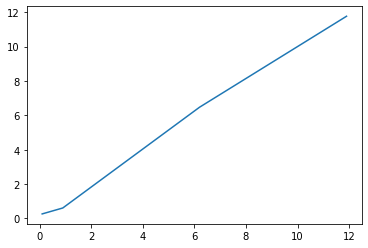

In [142]:
from sklearn.cross_decomposition import PLSRegression
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)

Y_pred = pls2.predict(X)
Y_pred, Y
plt.plot(np.array(Y)[:,0], np.array(Y_pred)[:,0])

In [143]:
x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_params = [p for p in param_cols_by_task if 'bf' in p]
len(x_params)

14

In [144]:
pls = PLSRegression(n_components=14)
pls.fit(all_data_z[x_params], all_data_z[y_params])

pred = pls.predict(all_data_z[x_params])
pls.score(all_data_z[x_params], all_data_z[y_params])  # R^2 of self.predict(X) wrt. y.

0.2043528077661077

In [145]:
pred = pd.DataFrame(pred, columns=y_params)
pred_l = pred.melt(var_name='param_name', value_name='param_value').reset_index()
true_l = all_data_z[y_params].melt(var_name='param_name', value_name='param_value').reset_index()
# dat = pd.merge(pred, all_data_z[y_params], left_index=True, right_index=True, suffixes=['_pred', '_true'])
# dat
dat_l = pd.merge(pred_l, true_l, on=['param_name', 'index'], suffixes=['_pred', '_true'])
dat_l

index param_name  param_value_pred  param_value_true
0         0   bf_alpha         -0.886638         -0.741288
1         1   bf_alpha          0.350769         -0.742421
2         2   bf_alpha          0.247939          2.384159
3         3   bf_alpha          0.751120         -0.393261
4         4   bf_alpha         -0.287798         -1.186291
...     ...        ...               ...               ...
1019   1019  bf_forget         -0.083788         -0.174755
1020   1020  bf_forget         -0.172996          1.582144
1021   1021  bf_forget          0.256411          0.571948
1022   1022  bf_forget          0.061806          2.164332
1023   1023  bf_forget          0.142688         -0.225710

[1024 rows x 4 columns]

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


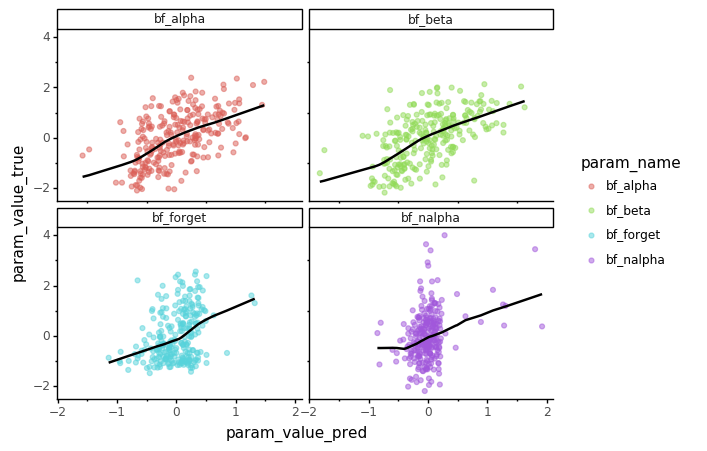

<ggplot: (-9223371927327653660)>

In [147]:
(gg.ggplot(dat_l, gg.aes('param_value_pred', 'param_value_true', color='param_name'))
 + gg.geom_point(alpha=0.5)
 + gg.geom_smooth(color='black')
 + gg.facet_wrap('~ param_name')
)

## Correlation between features

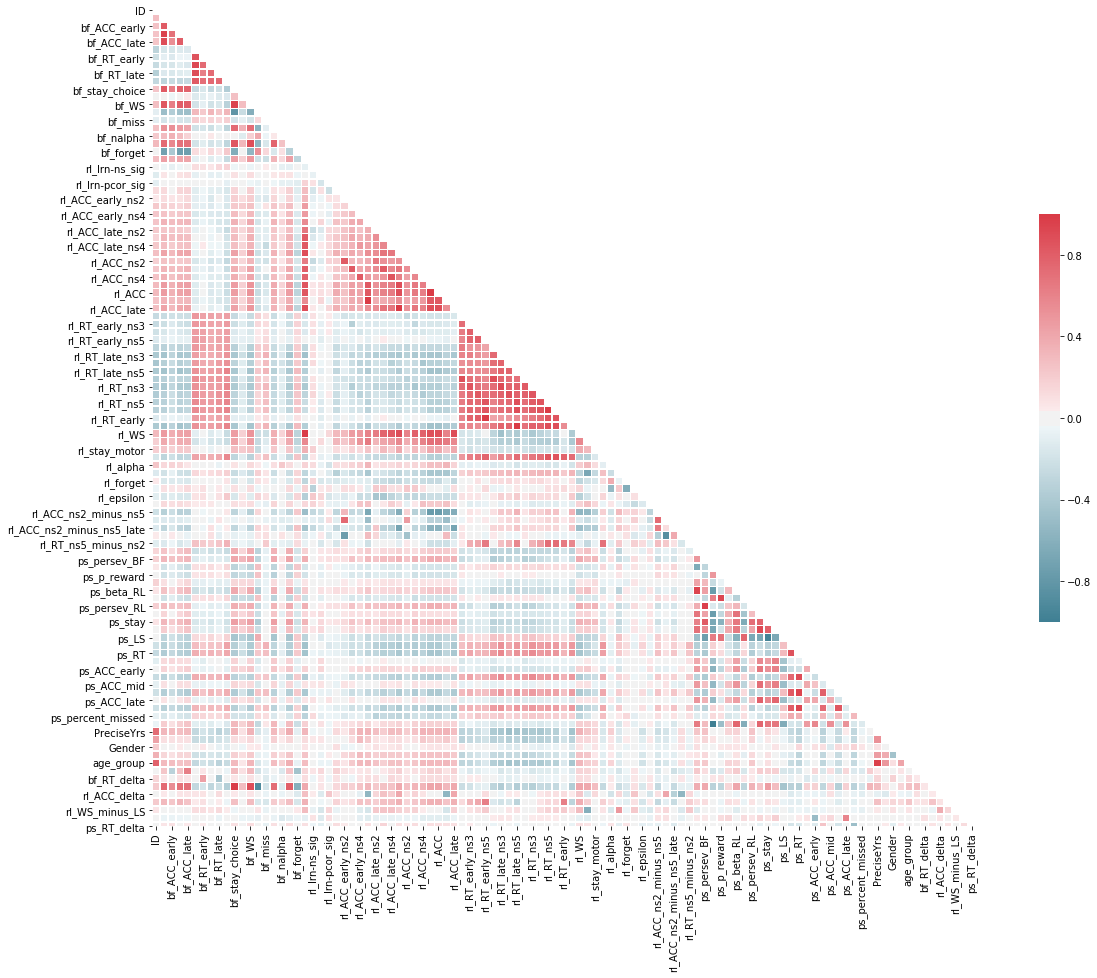

In [249]:
# Compute the correlation matrix
corr = all_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig(os.path.join(plot_save_path, '1CorrMatrixAll.png'))

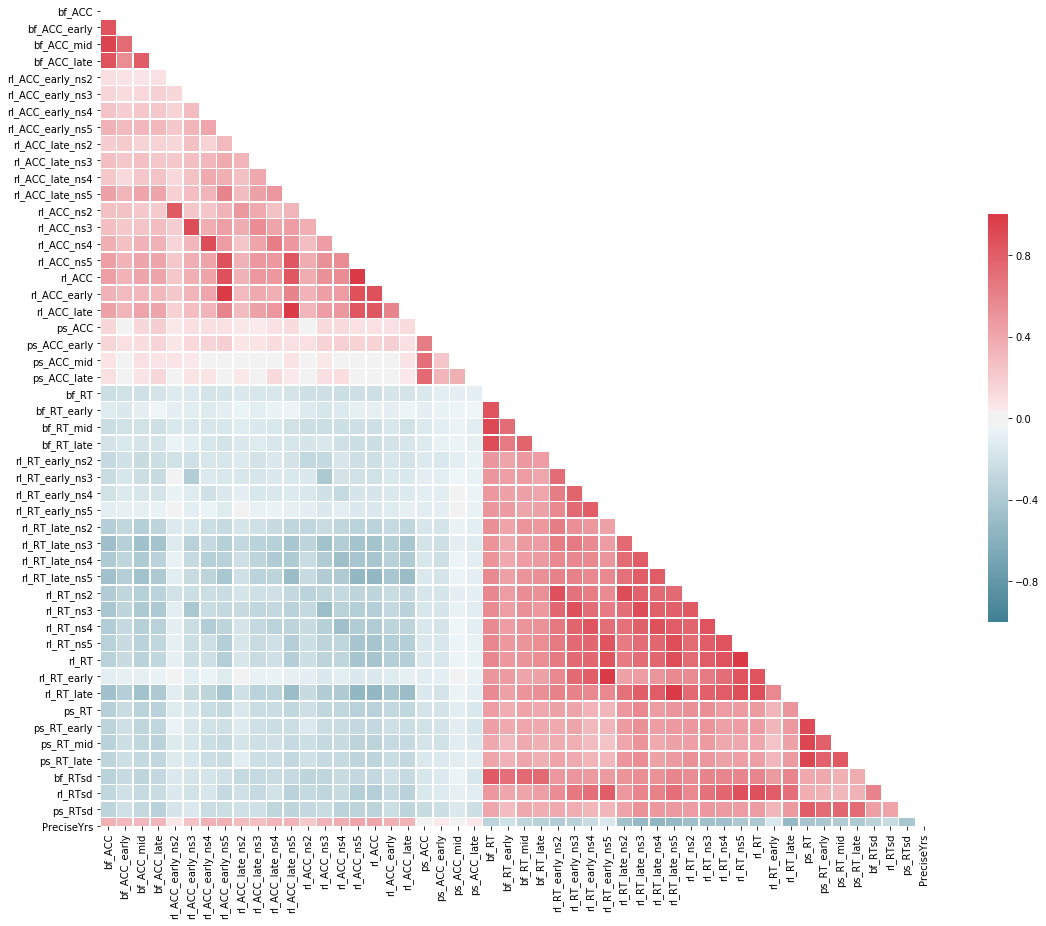

In [250]:
# Correlations between ACCs and RTs in different tasks
rt_cols = [col for col in all_data.columns if
           ('RT' in col) and ('sd' not in col) and ('delta' not in col) and ('minus' not in col)]
rtsd_cols = [col for col in all_data.columns if ('RT' in col) and ('sd' in col)]
acc_cols = [col for col in all_data.columns if
            ('ACC' in col) and ('sd' not in col) and ('delta' not in col) and ('minus' not in col)]

# Compute the correlation matrix
dat = all_data[acc_cols + rt_cols + rtsd_cols + ['PreciseYrs']]
# corr = dat.corr()
corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig(os.path.join(plot_save_path, '1CorrMatrixBehavior.png'))

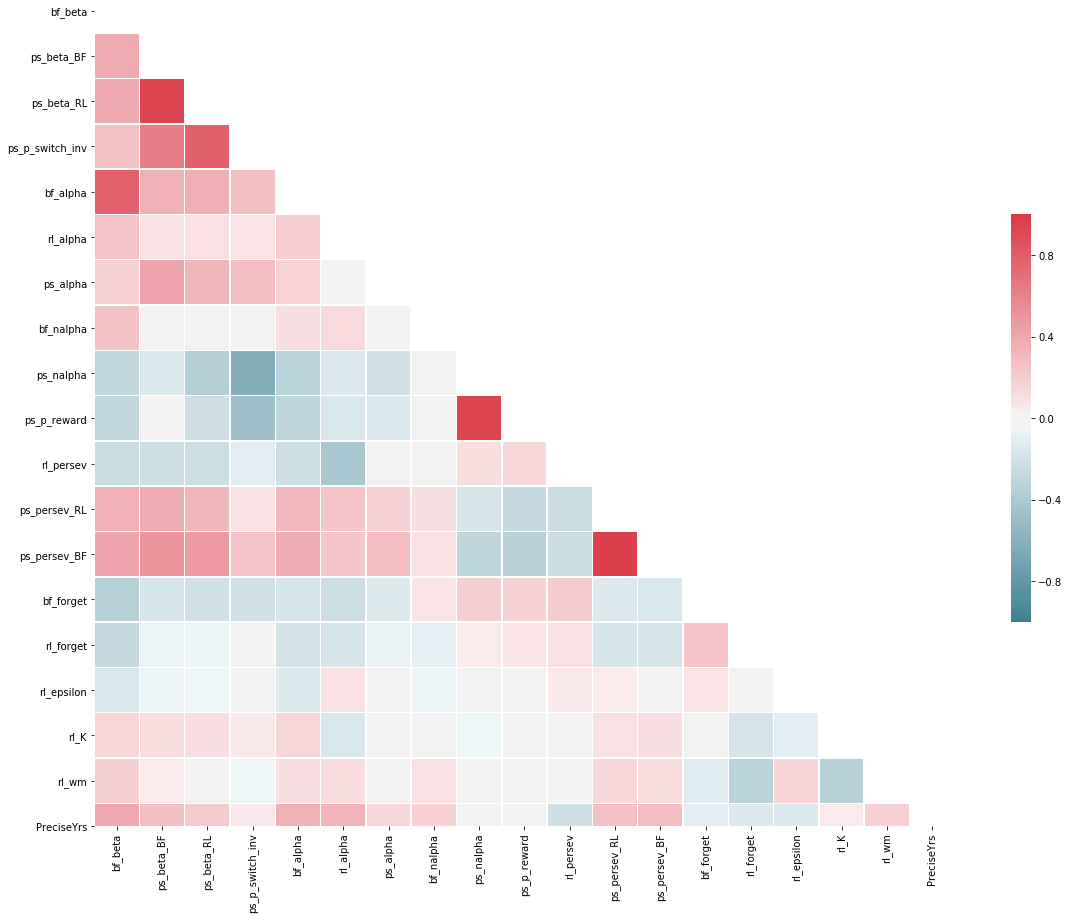

In [251]:
# Correlations between parameters in different tasks
param_cols_by_task = [
#     'fc_betas_1', 'fc_betas_2', 'fc_betas_3', 'fc_betas_4', 'fc_alpha', 'fc_beta', 'fc_ralpha',
    'bf_alpha', 'bf_nalpha', 'bf_beta', 'bf_forget',
    'rl_K', 'rl_alpha', 'rl_wm', 'rl_forget', 'rl_epsilon', 'rl_persev',
    'ps_beta_BF', 'ps_beta_RL', 'ps_persev_RL', 'ps_persev_BF', 'ps_alpha', 'ps_nalpha', 'ps_p_switch', 'ps_p_reward']

param_cols_by_param = [
    'bf_beta', 'ps_beta_BF', 'ps_beta_RL', 'ps_p_switch',
    'bf_alpha', 'rl_alpha', 'ps_alpha',
    'bf_nalpha', 'ps_nalpha', 'ps_p_reward',
    'rl_persev', 'ps_persev_RL', 'ps_persev_BF',
    'bf_forget', 'rl_forget',
    'rl_epsilon',
    'rl_K', 'rl_wm']

# Compute the correlation matrix
dat = all_data[param_cols_by_param + ['PreciseYrs']]
# dat = all_data[param_cols_by_task + ['PreciseYrs']]
# corr = dat.corr()
corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig(os.path.join(plot_save_path, '1CorrMatrixParams_param.png'))

# PCA on parameters

In [ ]:
# Run PCA
pca = PCA(n_components=z_dat[param_cols_by_param].shape[1])
# pca = KernelPCA(n_components=z_dat.shape[1])
fit = pca.fit_transform(z_dat[param_cols_by_param].dropna())
n_comp = 11

In [ ]:
# Explained variance
dat = pd.DataFrame({'PC': range(z_dat[param_cols_by_param].shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
g = (gg.ggplot(dat, gg.aes('PC', 'expl_var'))
 + gg.geom_point()
 + gg.geom_line()
 + gg.geom_hline(yintercept=1, linetype='dotted')
 + gg.geom_vline(xintercept=n_comp, linetype='dotted')
)
g.save(os.path.join(plot_save_path, '5PCAExplVar_params.png'))

expl_var_at_n_comp = list(dat[dat.PC <= n_comp].expl_var)[-1]
print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))
g

In [ ]:
pd.DataFrame(fit)

In [ ]:
# Age in PC space
fit_pd = pd.DataFrame(fit,
                      columns=['pc{}'.format(i) for i in range(z_dat[param_cols_by_param].shape[1])],
                      index=all_data.drop(columns=ages_cols[1:]).dropna().reset_index().ID)
fit_pd = fit_pd.reset_index()
fit_pd = fit_pd.merge(ages[ages_cols])

g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
 + gg.geom_point()
)
g1.save(os.path.join(plot_save_path, '5PCPC0PC1_param.png'))

g2 = g1 + gg.aes('pc2', 'pc3')
g2.save(os.path.join(plot_save_path, '5PCPC2PC3_param.png'))
g1, g2

In [ ]:
# PC changes over age
fit_long = fit_pd.melt(
    value_vars=['pc{}'.format(i) for i in range(n_comp)],
    id_vars=ages_cols)

gg.options.figure_size = (10, 8)
g = (gg.ggplot(fit_long, gg.aes('PreciseYrs', 'value'))
 + gg.geom_point(alpha=0.5, size=0.5)
 + gg.geom_smooth(color='red')
 + gg.facet_wrap('~ variable', scales='free')
)
g.save(os.path.join(plot_save_path, '5PCAAgePC.png'))
g

In [ ]:
g_t = g + gg.aes(x='meanT')
g.save(os.path.join(plot_save_path, '5PCATPC.png'))
g_t

In [ ]:
# Factor loadings
loadings = pca.components_[:n_comp].T  # (n_components, n_features)  * np.sqrt(pca.explained_variance_)
loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=sub_dat.columns)
loadings_pd = loadings_pd.reset_index()
loadings_long = loadings_pd.melt(
    value_vars=['pc{}'.format(i) for i in range(n_comp)],
    id_vars=['index'])

In [ ]:
loadings_long['task'] = loadings_long['index'].apply(lambda x : x[:3])
loadings_long['ACC_RT'] = loadings_long['index'].apply(name_from_index, names=['ACC', 'RT'])
loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[2:]))

In [ ]:
loadings_pd['param_name'] = loadings_pd['index'].apply(lambda x : x[3:])
loadings_pd['param_bool'] = loadings_pd['index'].apply(lambda x : x[:2])
loadings_pd['category'] = loadings_pd['param_name'].apply(name_from_index, names=param_names + ['ACC', 'RT'])
loadings_pd['ACC_RT'] = loadings_pd['param_name'].apply(name_from_index, names=['ACC', 'RT'])
loadings_pd['task'] = loadings_pd['index'].apply(lambda x: x[:2])
loadings_pd

In [ ]:
sub_dat = loadings_long[loadings_long['PC'] < 5]
g = (gg.ggplot(sub_dat, gg.aes('index', 'value', fill='ACC_RT'))
 + gg.geom_bar(stat='identity')
 + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
 + gg.facet_grid('variable ~ task', scales='free_x')
 + gg.labs(x='', y='Loading')
 + gg.theme(legend_position='none')
)
g.save(os.path.join(plot_save_path, '5PCALoadings.png'))
g

## PCA on behavior

In [ ]:
# Run PCA
beh_dat = all_data[acc_cols + rt_cols + rtsd_cols].dropna()
IDs = all_data[acc_cols + rt_cols + rtsd_cols + ['ID']].dropna().ID
pca = PCA(n_components=beh_dat.shape[1])
fit = pca.fit_transform(beh_dat)
n_comp = 6

In [ ]:
# Explained variance
gg.options.figure_size = (5, 5)
dat = pd.DataFrame({'PC': range(beh_dat.shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
g = (gg.ggplot(dat, gg.aes('PC', 'expl_var'))
 + gg.geom_point()
 + gg.geom_line()
 + gg.geom_hline(yintercept=1, linetype='dotted')
 + gg.geom_vline(xintercept=n_comp, linetype='dotted')
)
g.save(os.path.join(plot_save_path, '3PCAExplVar_params.png'))

expl_var_at_n_comp = list(dat[dat.PC <= n_comp].expl_var)[-1]
print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))
g

In [ ]:
# Age in PC space
fit_pd = pd.DataFrame(fit,
                      columns=['pc{}'.format(i) for i in range(beh_dat.shape[1])],
                      index=IDs)
fit_pd = fit_pd.reset_index()
fit_pd = fit_pd.merge(ages[ages_cols])

g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
 + gg.geom_point()
)
g1.save(os.path.join(plot_save_path, '3PCPC0PC1_beh.png'))

g2 = g1 + gg.aes('pc2', 'pc3')
g2.save(os.path.join(plot_save_path, '3PCPC2PC3_beh.png'))
g1, g2

In [ ]:
# PC changes over age
fit_long = fit_pd.melt(
    value_vars=['pc{}'.format(i) for i in range(n_comp)],
    id_vars=ages_cols)

gg.options.figure_size = (10, 8)
g = (gg.ggplot(fit_long, gg.aes('PreciseYrs', 'value'))
 + gg.geom_point(alpha=0.5, size=0.5)
 + gg.geom_smooth(color='red')
 + gg.facet_wrap('~ variable', scales='free')
)
g.save(os.path.join(plot_save_path, '3PCAAgePC.png'))
g

In [ ]:
pd.DataFrame(loadings)

In [ ]:
# Factor loadings
loadings = pca.components_[:n_comp].T  # (n_components, n_features)  * np.sqrt(pca.explained_variance_)
loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=beh_dat.columns)
loadings_pd = loadings_pd.reset_index()
loadings_long = loadings_pd.melt(
    value_vars=['pc{}'.format(i) for i in range(n_comp)],
    id_vars=['index'])

In [ ]:
loadings_long['task'] = loadings_long['index'].apply(lambda x : x[:3])
loadings_long['ACC_RT'] = loadings_long['index'].apply(name_from_index, names=['ACC', 'RT'])
loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[2:]))

In [ ]:
loadings_pd['param_name'] = loadings_pd['index'].apply(lambda x : x[3:])
loadings_pd['param_bool'] = loadings_pd['index'].apply(lambda x : x[:2])
loadings_pd['category'] = loadings_pd['param_name'].apply(name_from_index, names=param_names + ['ACC', 'RT'])
loadings_pd['ACC_RT'] = loadings_pd['param_name'].apply(name_from_index, names=['ACC', 'RT'])
loadings_pd['task'] = loadings_pd['index'].apply(lambda x: x[:2])
loadings_pd

In [ ]:
sub_dat = loadings_long[loadings_long['PC'] < 5]
g = (gg.ggplot(sub_dat, gg.aes('index', 'value', fill='ACC_RT'))
 + gg.geom_bar(stat='identity')
 + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
 + gg.facet_grid('variable ~ task', scales='free_x')
 + gg.labs(x='', y='Loading')
 + gg.theme(legend_position='none')
)
g.save(os.path.join(plot_save_path, '3PCALoadings_beh.png'))
g

## Z-score all features

In [ ]:
# Prepare data
sub_dat = all_data.drop(columns=ages_cols[1:])
z_dat = preprocessing.scale(sub_dat)
z_dat = pd.DataFrame(z_dat, columns=sub_dat.columns)
z_dat = z_dat.set_index(sub_dat.index)
z_dat

In [ ]:
z_dat_ages = z_dat.reset_index().merge(ages[ages_cols], on=['ID'])
z_dat_ages

In [ ]:
z_dat_long = z_dat.melt(var_name='feature')
z_dat_long['task'] = z_dat_long.feature.apply(lambda x : x[:2])
z_dat_long['param'] = z_dat_long.feature.apply(lambda x : x[3:])

g_z = g
g_z.data = z_dat_long
g_z

## Regression models

In [ ]:
# Run parameter regression models
r2s_param = pd.DataFrame()
coefs_param = pd.DataFrame()

for dep_var in param_cols_by_task:
    
    # Indep vars: all parameters of the other models
    indep_vars = '+'.join([p for p in param_cols_by_task if p[:2] != dep_var[:2]])
    model = smf.ols('{} ~ {}'.format(dep_var, indep_vars), data=z_dat).fit()
    
    model_r2 = pd.DataFrame({'R2': [model.rsquared], 'dep_var': [dep_var]})
    model_coefs_param = pd.DataFrame(model.params, columns=['coef'])
    model_coefs_param['dep_var'] = dep_var
    
    r2s_param = r2s_param.append(model_r2)
    coefs_param = coefs_param.append(model_coefs_param)

In [ ]:
# Run behavior regression models
r2s_beh = pd.DataFrame()
coefs_beh = pd.DataFrame()

for dep_var in acc_cols + rt_cols:
    
    # Predict with all behaviors of other models
    indep_vars = '+'.join([p for p in acc_cols + rt_cols if p[:2] != dep_var[:2]])
    model = smf.ols('{} ~ {}'.format(dep_var, indep_vars), data=z_dat).fit()
    
    model_r2 = pd.DataFrame({'R2': [model.rsquared], 'dep_var': [dep_var]})
    model_coefs_beh = pd.DataFrame(model.params, columns=['coef'])
    model_coefs_beh['dep_var'] = dep_var
    
    r2s_beh = r2s_beh.append(model_r2)
    coefs_beh = coefs_beh.append(model_coefs_beh)

In [ ]:
# Predict age from parameters
indep_vars = '+'.join(param_cols_by_param)
model_param = smf.ols('PreciseYrs ~ {}'.format(indep_vars), data=z_dat_ages).fit()
param_coefs = pd.DataFrame(model_param.params, columns=['coef'])
param_coefs['indep_var'] = 'parameters'

# Predict age from behavior
indep_vars = '+'.join(rt_cols + acc_cols)
model_beh = smf.ols('PreciseYrs ~ {}'.format(indep_vars), data=z_dat_ages).fit()
beh_coefs = pd.DataFrame(model_beh.params, columns=['coef'])
beh_coefs['indep_var'] = 'behavior'

# Predict age from all
indep_vars = '+'.join(param_cols_by_param + rt_cols + acc_cols)
model_all = smf.ols('PreciseYrs ~ {}'.format(indep_vars), data=z_dat_ages).fit()
all_coefs = pd.DataFrame(model_all.params, columns=['coef'])
all_coefs['indep_var'] = 'all'

r2s_age = pd.DataFrame({
    'dep_var': ['PreciseYrs'] * 3,
    'R2': [model_param.rsquared, model_beh.rsquared, model_all.rsquared],
    'indep_vars': ['parameters', 'behavior', 'all']
})

# coefs_age = param_coefs.append(beh_coefs).append(all_coefs)
all_coefs = all_coefs.reset_index()
all_coefs['task'] = all_coefs['index'].apply(lambda x : x[:2])
all_coefs = all_coefs[all_coefs['index'] != 'Intercept']
all_coefs['category'] = all_coefs['index'].apply(name_from_index, names=param_names+['ACC', 'RT'])
# all_coefs

In [ ]:
# Beautify data
r2s_param = r2s_param.reset_index(drop=True)
r2s_param['task'] = r2s_param.dep_var.apply(lambda x : x[:2])
r2s_param['param'] = r2s_param.dep_var.apply(lambda x : x[3:])

coefs_param['task'] = coefs_param.dep_var.apply(lambda x : x[:2])
coefs_param['param'] = coefs_param.dep_var.apply(lambda x : x[3:])

r2s_beh = r2s_beh.reset_index(drop=True)
r2s_beh['task'] = r2s_beh.dep_var.apply(lambda x : x[:2])
r2s_beh['param'] = r2s_beh.dep_var.apply(lambda x : x[3:])
r2s_beh['category'] = r2s_beh['param'].apply(name_from_index, names=['ACC', 'RT'])

coefs_beh['task'] = coefs_beh.dep_var.apply(lambda x : x[:2])
coefs_beh['param'] = coefs_beh.dep_var.apply(lambda x : x[3:])
coefs_beh['category'] = coefs_beh['param'].apply(name_from_index, names=['RT', 'ACC'])

In [ ]:
# Predicting age
gg.options.figure_size = (5, 5)
g = (gg.ggplot(all_coefs, gg.aes('index', 'abs(coef)', fill='category'))
     + gg.stat_summary(geom='bar')
     + gg.stat_summary(geom='pointrange')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
     + gg.facet_wrap('~ task', scales='free_x')
     + gg.labs(x='', y='Weight when predicting age')
    )
g.save(os.path.join(plot_save_path, '3PredictingAgeCoefs.png'))
g

In [ ]:
g = (gg.ggplot(r2s_age, gg.aes('indep_vars', 'R2'))
     + gg.geom_bar(stat='identity')
     + gg.coord_cartesian(ylim=(0, 1))
     + gg.labs(x='', y='R2 when predicting age')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
    )
g.save(os.path.join(plot_save_path, '3PredictingAgeR2.png'))
g

In [ ]:
# Predicting parameters
gg.options.figure_size = (7, 5)
g = (gg.ggplot(r2s_param, gg.aes('param', 'R2', fill='param'))
     + gg.geom_bar(stat='identity')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1),
                legend_position='none')
     + gg.facet_wrap('~ task', scales='free_x')
     + gg.labs(x='', y='R2 when predicting each parameter')
)
g.save(os.path.join(plot_save_path, '3PredictingParamsR2.png'))
g

In [ ]:
g_beh = g + gg.aes(fill='category') + gg.labs(y='R2 when predicting behaviors')
g_beh.data = r2s_beh
g_beh.save(os.path.join(plot_save_path, '3PredictingBehaviorR2.png'))
g_beh

In [ ]:
# Plot coefficients
g = (gg.ggplot(coefs_param, gg.aes('param', 'abs(coef)', fill='param'))
#      + gg.geom_point(position='jitter', size=0.1)
     + gg.stat_summary(geom='bar')
     + gg.stat_summary(geom='pointrange')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1),
                legend_position='none')
     + gg.facet_wrap('~ task', scales='free_x')
     + gg.labs(x='', y='Weight when predicting parameters')
    )
g.save(os.path.join(plot_save_path, '3PredictingParamsCoefs.png'))
g

In [ ]:
g_beh = g + gg.aes(fill='category') + gg.labs(y = 'Weight when predicting behaviors')
g_beh.data = coefs_beh
g_beh.save(os.path.join(plot_save_path, '3PredictingBehaviorCoefs.png'))
g_beh

# Dendrograms

In [ ]:
sns.clustermap(all_data[acc_cols + rt_cols + ['PreciseYrs']].dropna(), z_score=1)
sns.clustermap(all_data[param_cols_by_param + ['PreciseYrs']].dropna(), z_score=1)
plt.savefig(os.path.join(plot_save_path, '4DendrogramBeh_param.png'))

# tSNE

In [ ]:
# Show participants in 2D space
tsne_dat = TSNE(n_components=2).fit_transform(z_dat.dropna())
index = all_data.reset_index().drop(columns=ages_cols[1:]).dropna().ID
tsne_pd = pd.DataFrame(tsne_dat, columns=['tSNE1', 'tSNE2'], index=index).reset_index()
tsne_pd = tsne_pd.merge(ages[['ID', 'PreciseYrs', 'Gender', 'meanT']])

In [ ]:
gg.options.figure_size = (5, 4)
g = (gg.ggplot(tsne_pd, gg.aes('tSNE1', 'tSNE2', color='PreciseYrs'))
 + gg.geom_point()
)
g.save(os.path.join(plot_save_path, '4TsneParticipants.png'))
g

In [ ]:
tsne_long = tsne_pd.melt(id_vars=['ID', 'PreciseYrs', 'Gender', 'meanT'])
g = (gg.ggplot(tsne_long, gg.aes('PreciseYrs', 'value'))
 + gg.geom_point()
 + gg.geom_smooth()
 + gg.facet_grid('~ variable')
)
g.save(os.path.join(plot_save_path, '4TsneParticipants_.png'))
g

In [ ]:
# Show measures in 2D space
tsne_dat = TSNE(n_components=2).fit_transform(z_dat.dropna().T)
tsne_pd = pd.DataFrame(tsne_dat, columns=['tSNE1', 'tSNE2'], index=z_dat.columns).reset_index()
tsne_pd['task'] = tsne_pd['index'].apply(lambda x : x[:2])
tsne_pd['param_name'] = tsne_pd['index'].apply(name_from_index)
tsne_pd['ACC_RT'] = tsne_pd['index'].apply(name_from_index, names=['ACC', 'RT'])
tsne_pd['param_bool'] = tsne_pd['index'].apply(bool_from_index)
tsne_pd

In [ ]:
gg.options.figure_size = (5, 4)
g = (gg.ggplot(tsne_pd, gg.aes('tSNE1', 'tSNE2', color='task'))
 + gg.geom_point()
)
g.save(os.path.join(plot_save_path, '4TsneFeaturesBeh_task.png'))
g

# Transforming RLWM regression weights

In [ ]:
all_data['rl_lrn-fix'].describe()
all_data['rl_lrn-fix_sig'].describe()
zscore(all_data['rl_lrn-fix']).describe()

In [ ]:
x = np.arange(-30, 30, 0.1)
# x = np.arange(-10, 10, 0.01)
# dat = pd.DataFrame({'x': x, 'y': 3 *sigmoid(x/3)})
# dat = pd.DataFrame({'x': x, 'y': sigmoid(x)})
dat = pd.DataFrame({'x': x, 'y': sigmoid(zscore(x))})
dat
(gg.ggplot(dat, gg.aes('x', 'y')) +
 gg.geom_point()
)

In [ ]:
# all_data['rl_lrn-fix_sig'] = sigmoid(zscore(all_data['rl_lrn-fix']))
all_data['rl_lrn-fix_sig'] = sigmoid(all_data['rl_lrn-fix'])
# all_data['rl_lrn-fix_sig'] = 50 * sigmoid(all_data['rl_lrn-fix'] / 50)
# all_data['rl_lrn-fix_sig'] = all_data['rl_lrn-fix_sig'].median() * sigmoid(all_data['rl_lrn-fix'] / all_data['rl_lrn-fix_sig'].median())

(gg.ggplot(all_data, gg.aes('rl_lrn-fix', 'rl_lrn-fix_sig')) +
 gg.geom_point()
)

In [ ]:
dat = all_data#[all_data['rl_lrn-fix'] < 50]
(gg.ggplot(dat, gg.aes('PreciseYrs', 'rl_lrn-fix_sig'))
 + gg.geom_point()
 + gg.geom_smooth()
)

In [ ]:
dat = all_data[all_data['rl_lrn-fix'] < 50]
(gg.ggplot(dat, gg.aes('PreciseYrs', 'rl_lrn-fix'))
 + gg.geom_point()
 + gg.geom_smooth()
)

In [ ]:
(gg.ggplot(all_data, gg.aes('PreciseYrs', 'rl_lrn-ns'))
 + gg.geom_point()
)

In [ ]:
(gg.ggplot(all_data, gg.aes('PreciseYrs', 'rl_lrn-pcor'))
 + gg.geom_point()
)

In [ ]:
(gg.ggplot(all_data, gg.aes('PreciseYrs', 'rl_lrn-pinc'))
 + gg.geom_point()
)